# Analyzing Attention Patterns in Transformer-based Decision Making

This notebook explores the attention mechanisms in transformer models trained on decision sequences. We'll visualize and analyze what is represented in the attention matrices that lead to decision-making outputs (R, r, L, l).


In [1]:

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model, parse_simulated_data, get_data_filenames, add_sequence_columns
# import interpretability.interp_helpers as interp
# import utils.file_management as fm

%load_ext autoreload
%autoreload 2

# Set plot style
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })


In [2]:

def encode_sequence(seq, stoi):
    """Convert string sequence to tensor of token indices"""
    indices = [stoi[c] for c in seq]
    return torch.tensor(indices, dtype=torch.long).unsqueeze(0).to("cuda")

def get_attention_maps(model, input_ids):
    """Get attention weights for each layer and head"""
    B, T = input_ids.size()
    assert T <= model.config.block_size, f"Sequence length {T} exceeds block size {model.config.block_size}"
    
    # Start with token and position embeddings
    pos = torch.arange(0, T, dtype=torch.long, device=input_ids.device)
    x = model.transformer.wte(input_ids) + model.transformer.wpe(pos)
    
    # Storage for attention weights from all layers
    attention_maps = []
    
    # Forward pass through each transformer block
    for block in model.transformer.h:
        # Layer normalization before attention
        ln_x = block.ln_1(x)
        
        # Extract components for attention computation
        qkv = block.attn.c_attn(ln_x)
        q, k, v = qkv.split(model.config.n_embd, dim=2)
        
        # Reshape for multi-head attention
        n_head = block.attn.n_head
        head_size = model.config.n_embd // n_head
        
        q = q.view(B, T, n_head, head_size).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, n_head, head_size).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, n_head, head_size).transpose(1, 2)  # (B, nh, T, hs)
        
        # Compute attention scores and apply mask
        att = (q @ k.transpose(-2, -1)) * (1.0 / (head_size ** 0.5))  # (B, nh, T, T)
        mask = block.attn.bias[:, :, :T, :T]
        att = att.masked_fill(mask == 0, float('-inf'))
        att = F.softmax(att, dim=-1)  # (B, nh, T, T)
        
        # Store attention weights
        attention_maps.append(att.detach().cpu().numpy())
        
        # Continue with forward pass
        y = (att @ v).transpose(1, 2).contiguous().view(B, T, model.config.n_embd)
        y = block.attn.c_proj(y)
        x = x + y
        x = x + block.mlp(block.ln_2(x))
    
    return attention_maps

def predict_next_token(model, input_ids):
    """Get model prediction for the next token"""
    with torch.no_grad():
        logits, _ = model(input_ids)
        next_token_logits = logits[:, -1, :]
        probs = F.softmax(next_token_logits, dim=-1)
        return probs.detach().cpu().numpy()[0]

## 1. Helper Functions for Extracting Attention Patterns


In [3]:

# Choose a run number based on available models
run = 2  # You may need to change this based on available models

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print number of parameters and important metadata
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Number of layers: {config.n_layer}")
print(f"Number of attention heads: {config.n_head}")
print(f"Embedding dimension: {config.n_embd}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Block size (context length): {config.block_size}")




Using cuda device
Total number of parameters: 202624
Number of layers: 4
Number of attention heads: 4
Embedding dimension: 64
Vocabulary size: 4
Block size (context length): 36


In [4]:

# Define vocabulary mapping
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}

# Get sequence length from the model info
T = model_info['dataloader']['Sequence length (T)']
print(f"Sequence length: {T}")

# Load data
events = parse_simulated_data(*get_data_filenames(run, suffix='v'))
events = add_sequence_columns(events, T)

# Get common sequences for analysis
vc = events[f'seq{T}_RL'].value_counts()
common_sequences = vc[vc > 50].index.tolist()[:10]  # Top 10 common sequences
print(f"Most common sequences:\n{common_sequences}")

Sequence length: 36
Most common sequences:
['LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR', 'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr', 'LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL', 'LLLLLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLL', 'LLLLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLL', 'LLLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLL', 'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLlLL', 'LLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLLL']


## 2. Visualizing Attention Patterns for Specific Sequences

In [5]:

def plot_attention_head(att_map, head_idx, sequence, ax=None, title=None):
    """Plot attention pattern for a specific head"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract attention matrix for the specified head
    att = att_map[0, head_idx]
    
    # Create a heatmap
    sns.heatmap(att, annot=True, fmt='.2f', cmap='viridis', 
                xticklabels=list(sequence), yticklabels=list(sequence),
                ax=ax, cbar=False, square=True, annot_kws={"size": 12})
    
    if title:
        ax.set_title(title, fontsize=14)
    else:
        ax.set_title(f'Head {head_idx}', fontsize=14)
        
    ax.set_xlabel('Key (attended to)', fontsize=12)
    ax.set_ylabel('Query (attending)', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    return ax

def plot_all_attention_heads(att_map, sequence, layer_idx):
    """Plot attention patterns for all heads in a given layer"""
    n_heads = att_map.shape[1]
    n_cols = min(4, n_heads)
    n_rows = (n_heads + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    fig.suptitle(f'Layer {layer_idx} - Attention Heads', fontsize=18)
    
    if n_heads == 1:
        plot_attention_head(att_map, 0, sequence, ax=axes)
    else:
        for h in range(n_heads):
            if n_rows > 1:
                row, col = h // n_cols, h % n_cols
                ax = axes[row, col]
            else:
                ax = axes[h]
            
            plot_attention_head(att_map, h, sequence, ax=ax)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

def visualize_sequence_attention(sequence, layer_idx=None):
    """Visualize attention patterns for a specific sequence"""
    # Encode the sequence
    input_ids = encode_sequence(sequence, stoi)
    
    # Get attention maps
    attention_maps = get_attention_maps(model, input_ids)
    
    # Get next token prediction
    probs = predict_next_token(model, input_ids)
    next_token_pred = vocab[np.argmax(probs)]
    
    print(f"Sequence: {sequence}")
    print(f"Predicted next token: {next_token_pred}")
    print(f"Token probabilities: {dict(zip(vocab, probs.round(3)))}")
    
    # Visualize attention for the specified layer or all layers
    if layer_idx is not None:
        return plot_all_attention_heads(attention_maps[layer_idx], sequence, layer_idx)
    else:
        # Visualize attention for all layers
        figs = []
        for i, att_map in enumerate(attention_maps):
            fig = plot_all_attention_heads(att_map, sequence, i)
            figs.append(fig)
        return figs
    
#Longer version for model #2
def plot_attention_head(att_map, head_idx, sequence, ax=None, title=None):
    """Plot attention pattern for a specific head, optimized for long sequences"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract attention matrix for the specified head
    att = att_map[0, head_idx]
    
    # For long sequences, don't show annotations
    seq_length = len(sequence)
    show_annot = seq_length <= 20  # Only show text annotations for shorter sequences
    
    # Create a heatmap
    sns.heatmap(att, annot=show_annot, fmt='.2f' if show_annot else '', 
                cmap='viridis', ax=ax, cbar=True, square=True,
                xticklabels=5 if seq_length > 15 else list(sequence),  # Show every 5th label
                yticklabels=5 if seq_length > 15 else list(sequence))  # Show every 5th label
    
    if title:
        ax.set_title(title, fontsize=14)
    else:
        ax.set_title(f'Head {head_idx}', fontsize=14)
        
    ax.set_xlabel('Key (attended to)', fontsize=12)
    ax.set_ylabel('Query (attending)', fontsize=12)
    
    # For long sequences, rotate tick labels
    if seq_length > 10:
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    return ax

def visualize_sequence_attention(sequence, layer_idx=None):
    """Visualize attention patterns for a specific sequence"""
    # Encode the sequence
    input_ids = encode_sequence(sequence, stoi)
    
    # Get attention maps
    attention_maps = get_attention_maps(model, input_ids)
    
    # Get next token prediction
    probs = predict_next_token(model, input_ids)
    next_token_pred = vocab[np.argmax(probs)]
    
    print(f"Sequence: {sequence}")
    print(f"Predicted next token: {next_token_pred}")
    print(f"Token probabilities: {dict(zip(vocab, probs.round(3)))}")
    
    # Visualize attention for the specified layer
    if layer_idx is not None:
        return plot_all_attention_heads(attention_maps[layer_idx], sequence, layer_idx)
    else:
        # For brevity, only visualize the first layer
        return plot_all_attention_heads(attention_maps[0], sequence, 0)


## 3. Attention Matrices for Common Decision Sequences


Analyzing sequence 1/5: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Sequence: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Predicted next token: L
Token probabilities: {'R': 0.004, 'r': 0.022, 'L': 0.862, 'l': 0.112}

Viewing Layer 0 attention patterns:


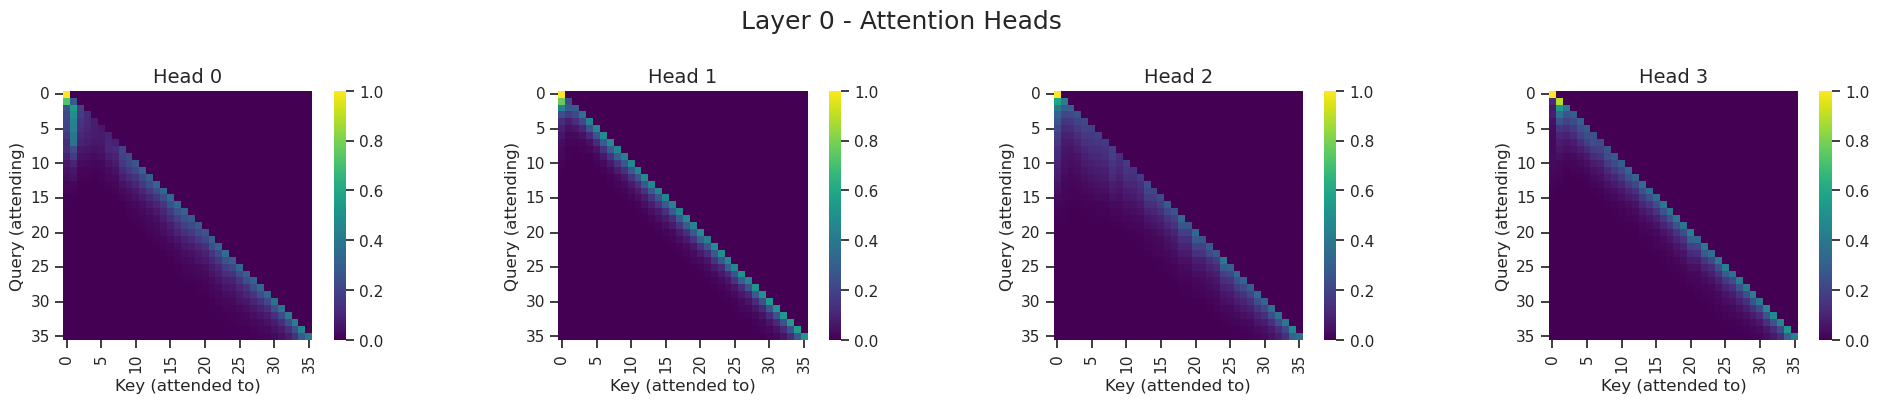


Viewing Layer 1 attention patterns:


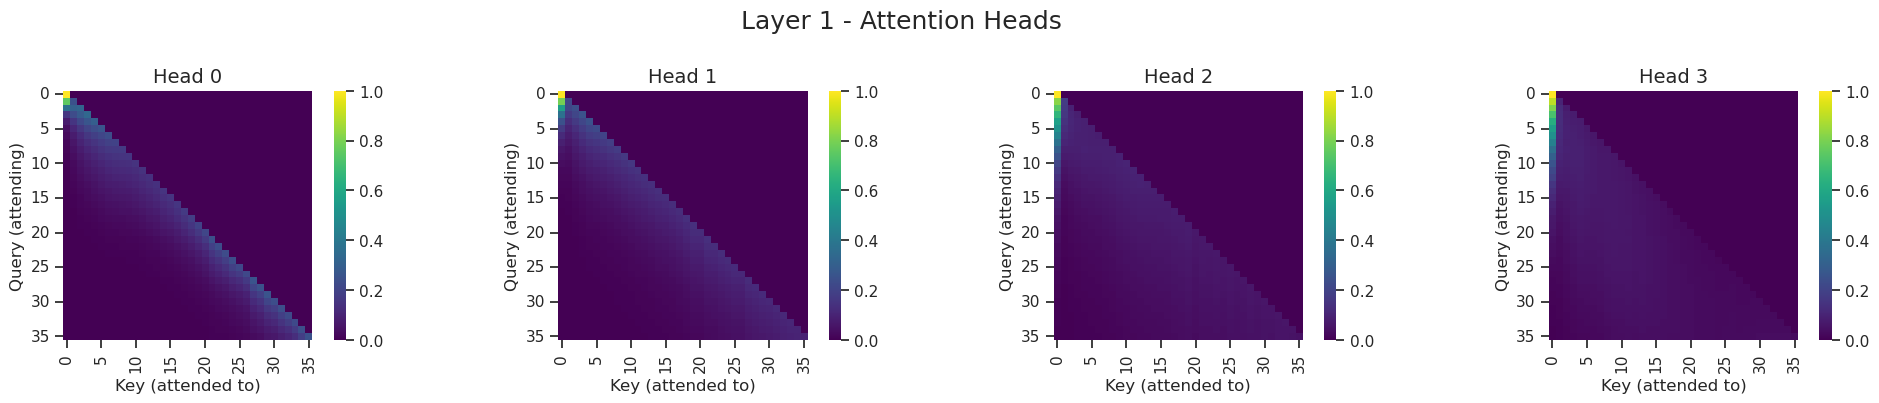


Viewing Layer 2 attention patterns:


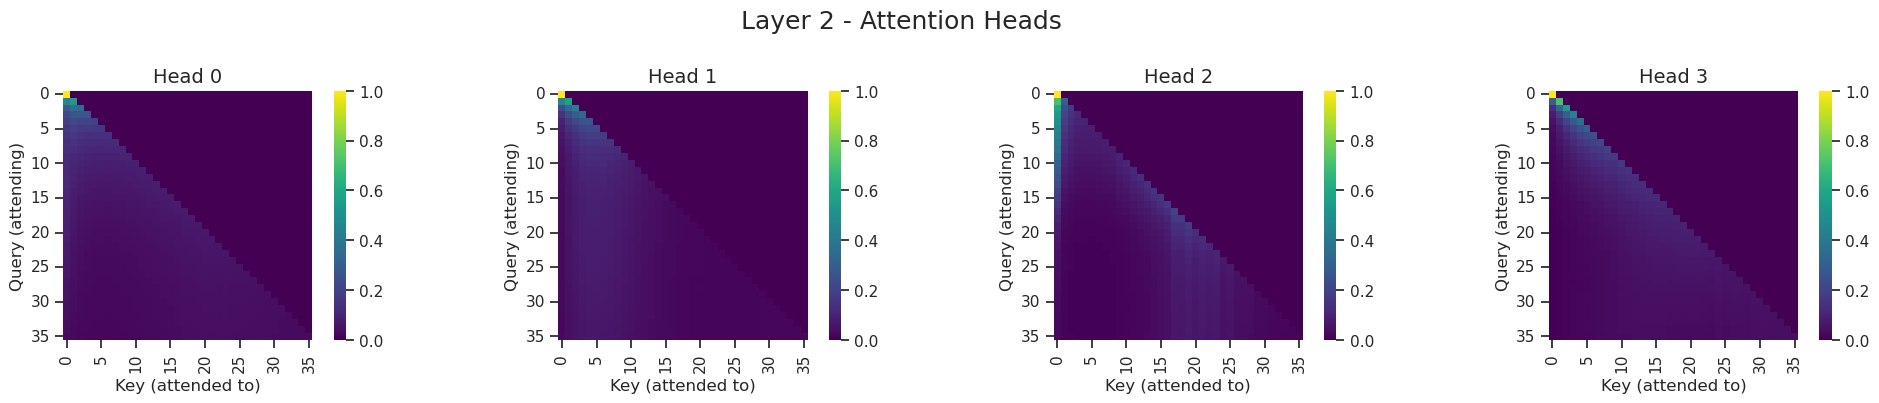


Viewing Layer 3 attention patterns:


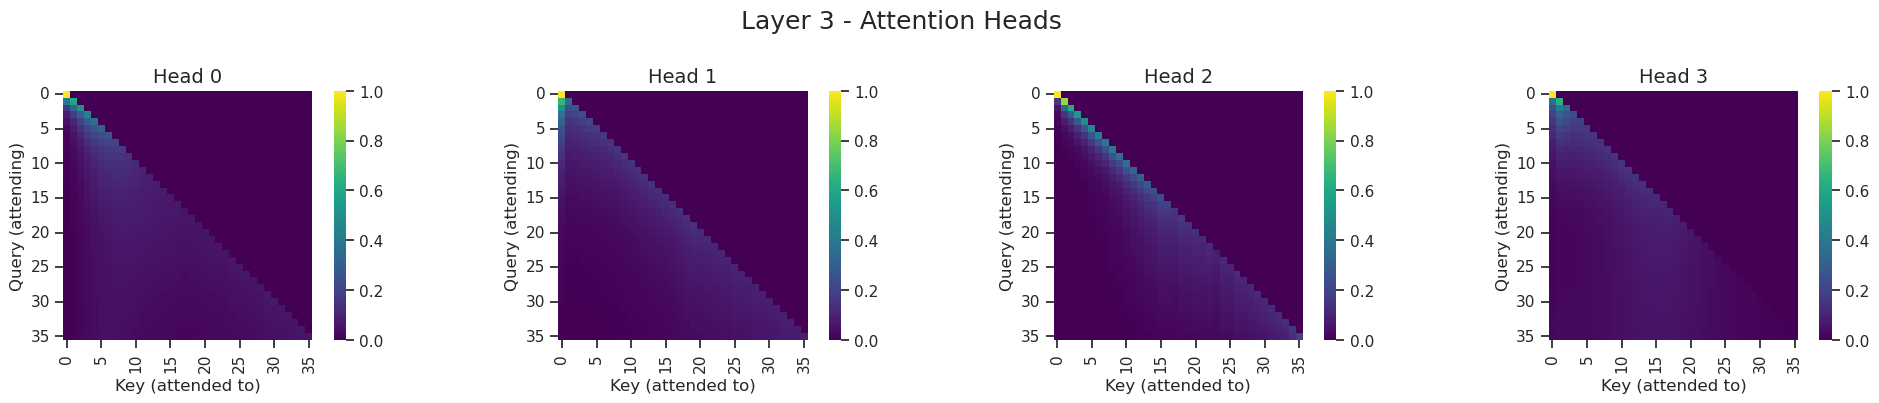


Analyzing sequence 2/5: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
Sequence: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
Predicted next token: R
Token probabilities: {'R': 0.877, 'r': 0.105, 'L': 0.002, 'l': 0.016}

Viewing Layer 0 attention patterns:


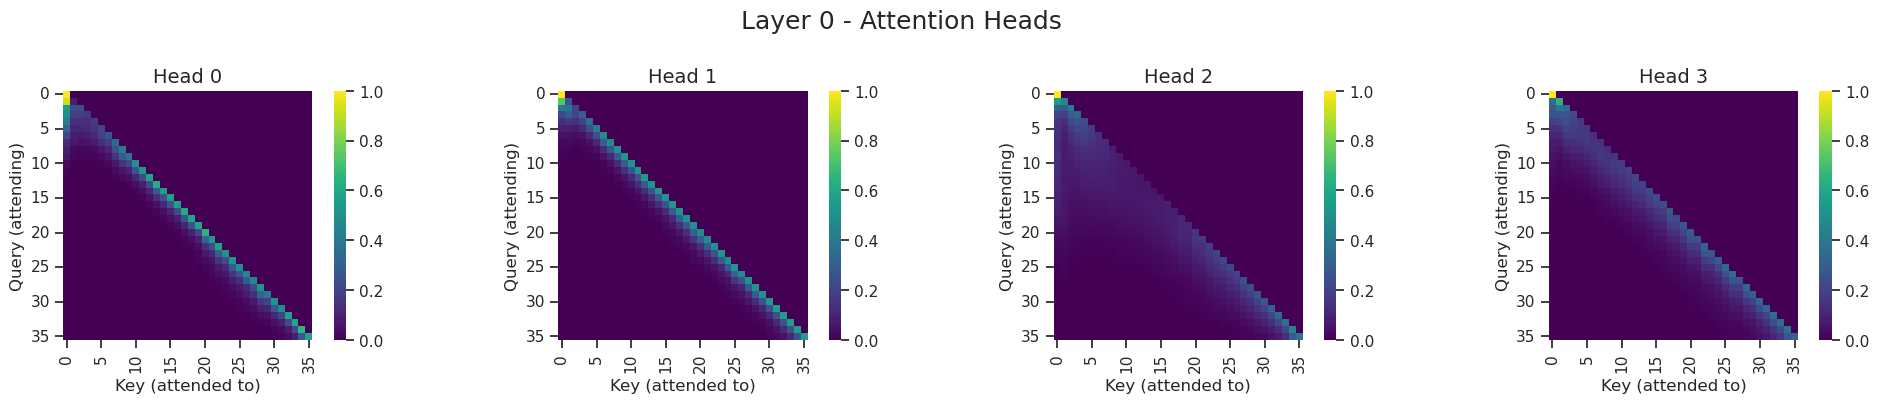


Viewing Layer 1 attention patterns:


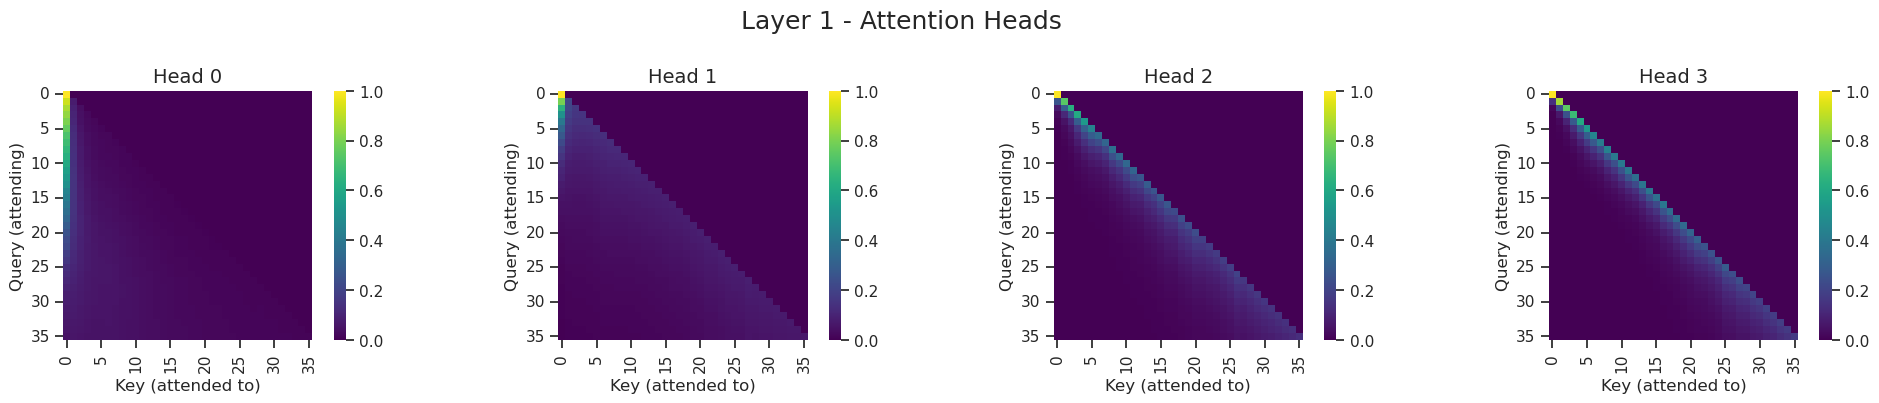


Viewing Layer 2 attention patterns:


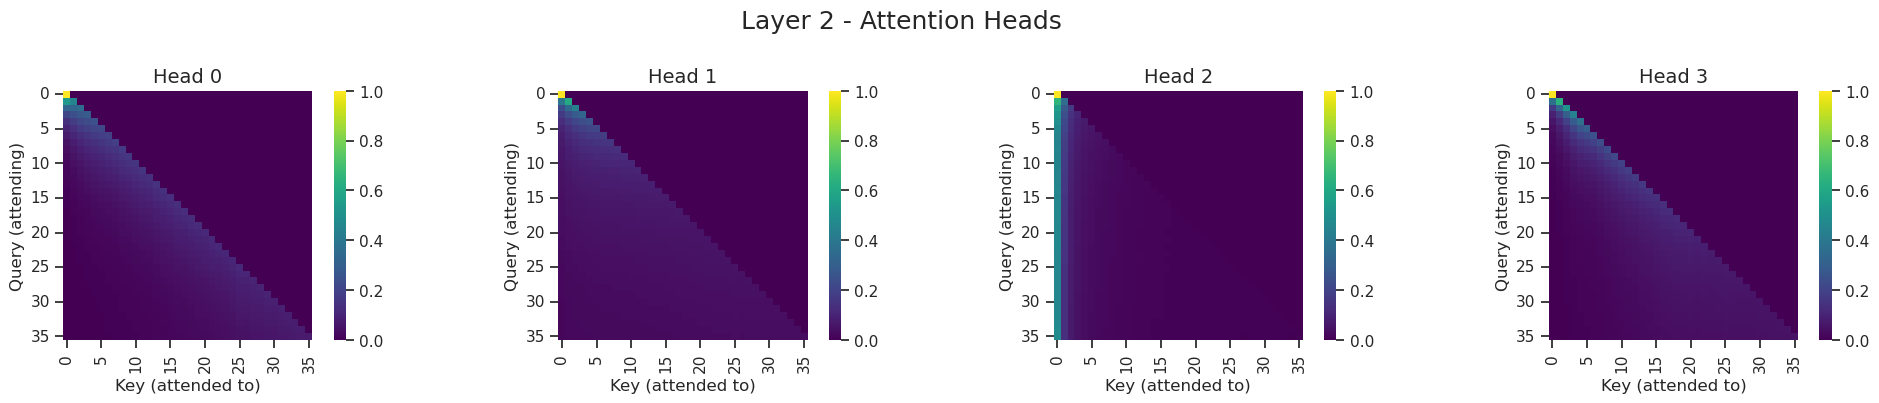


Viewing Layer 3 attention patterns:


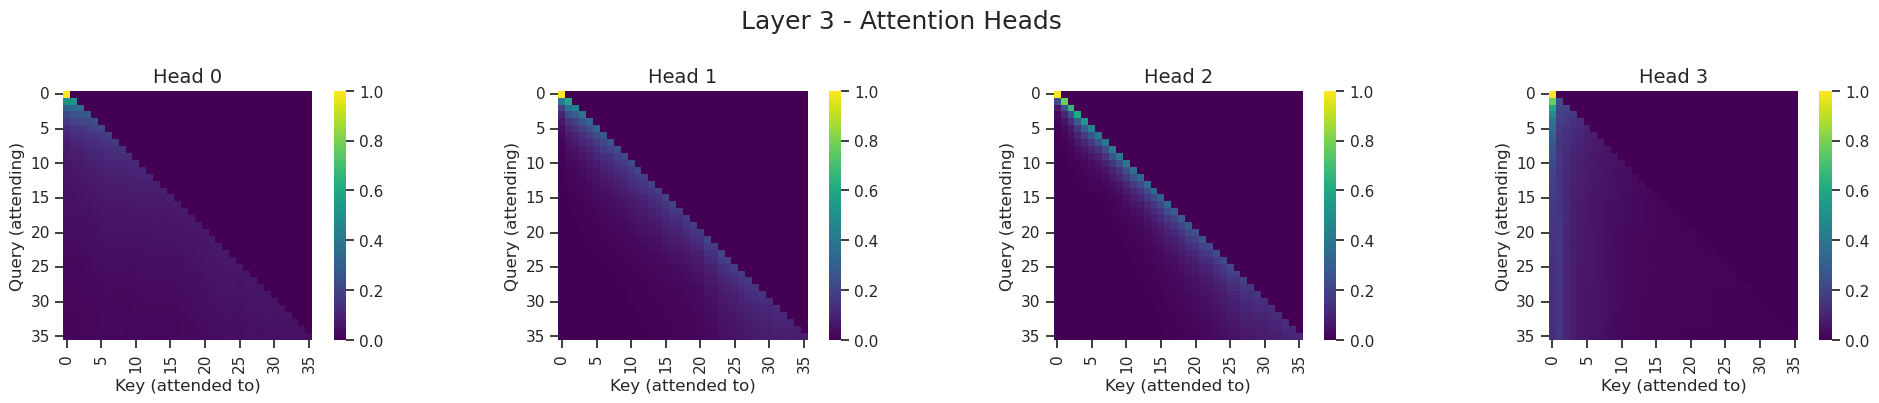


Analyzing sequence 3/5: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl
Sequence: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl
Predicted next token: L
Token probabilities: {'R': 0.03, 'r': 0.075, 'L': 0.657, 'l': 0.237}

Viewing Layer 0 attention patterns:


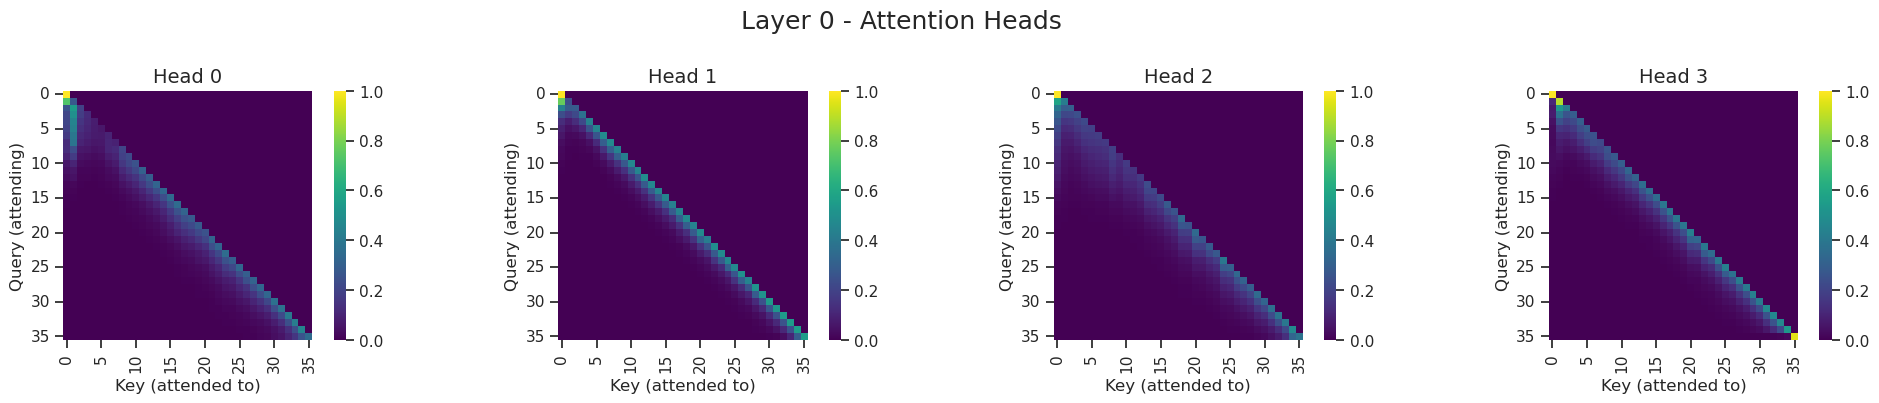


Viewing Layer 1 attention patterns:


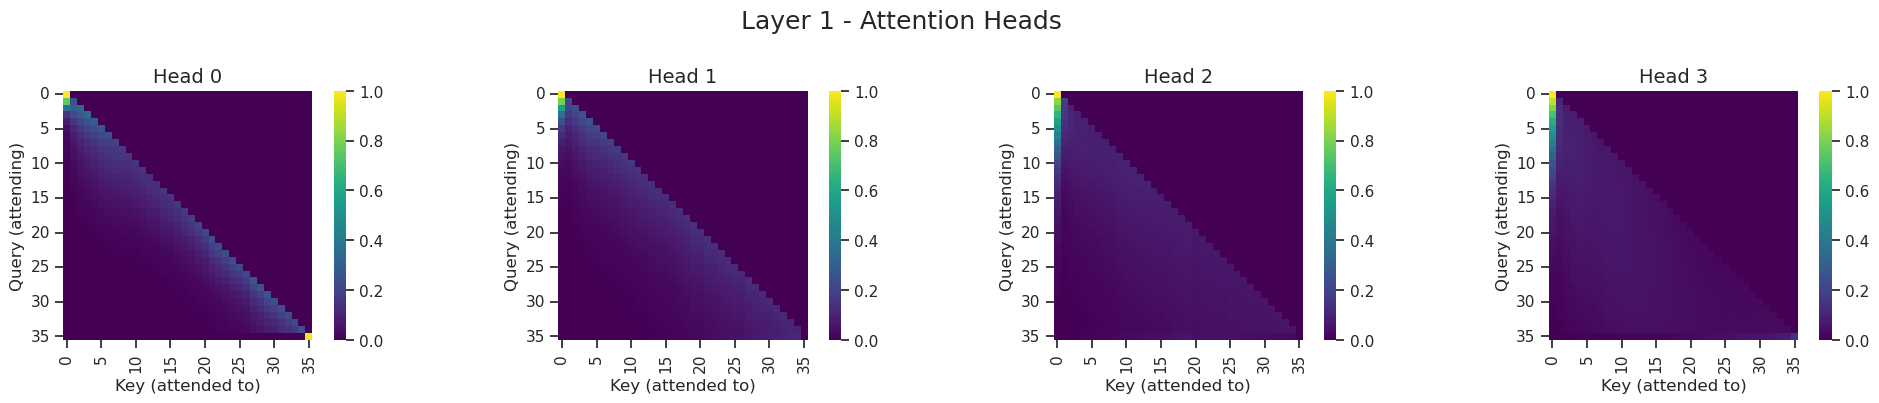


Viewing Layer 2 attention patterns:


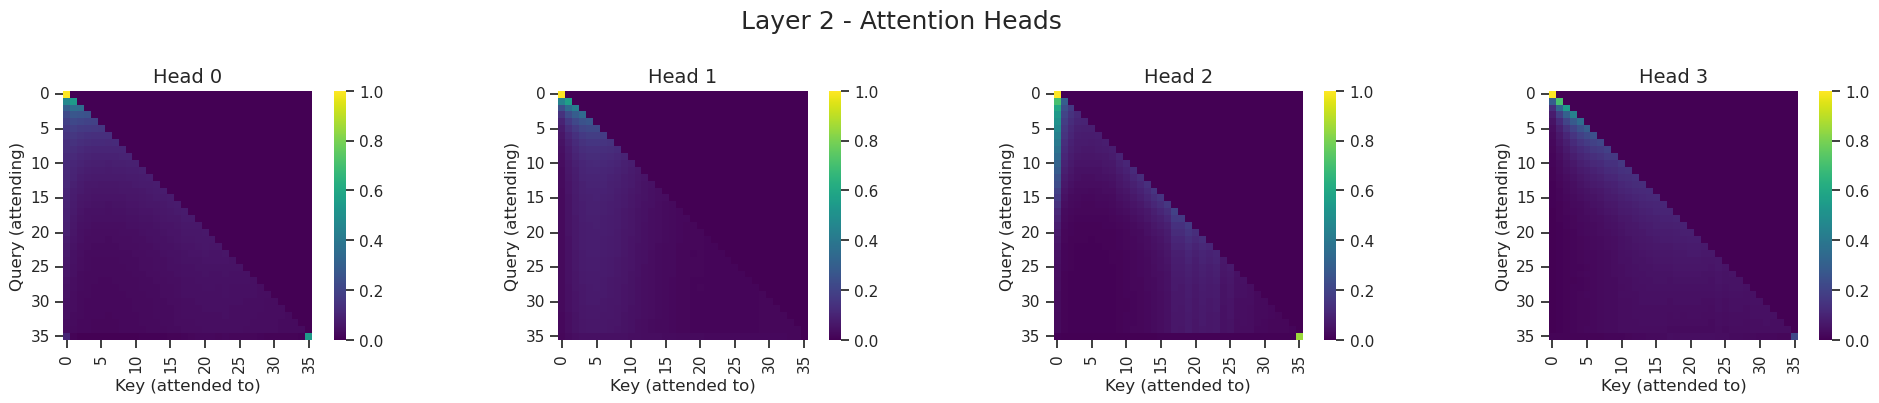


Viewing Layer 3 attention patterns:


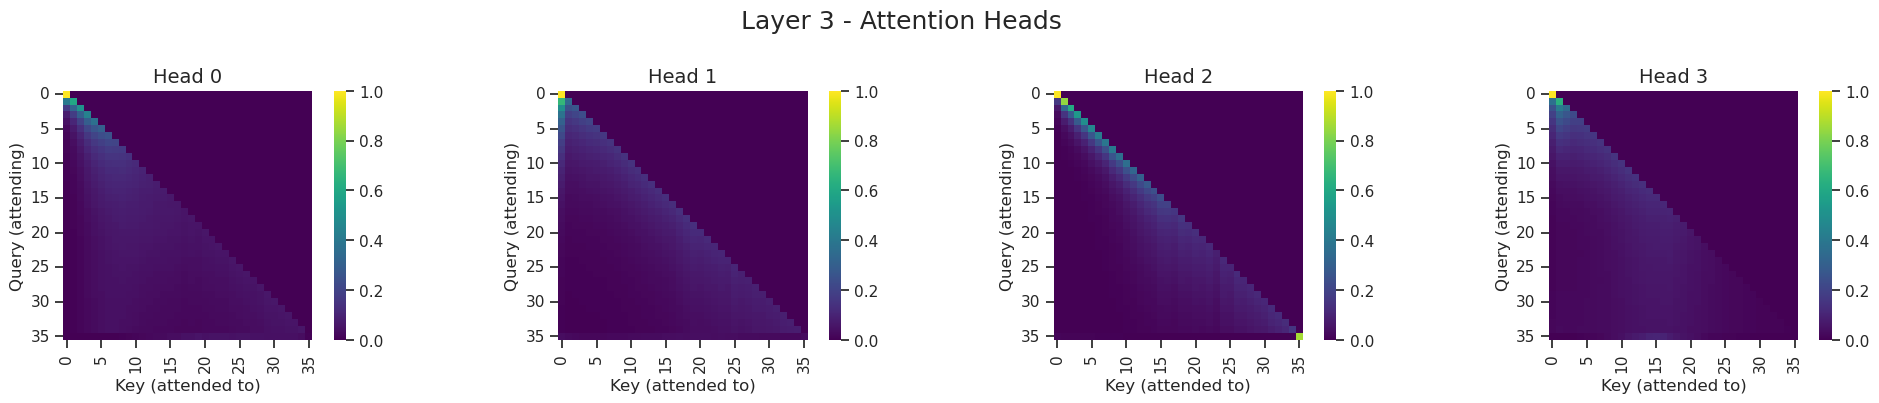


Analyzing sequence 4/5: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr
Sequence: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr
Predicted next token: R
Token probabilities: {'R': 0.712, 'r': 0.195, 'L': 0.021, 'l': 0.071}

Viewing Layer 0 attention patterns:


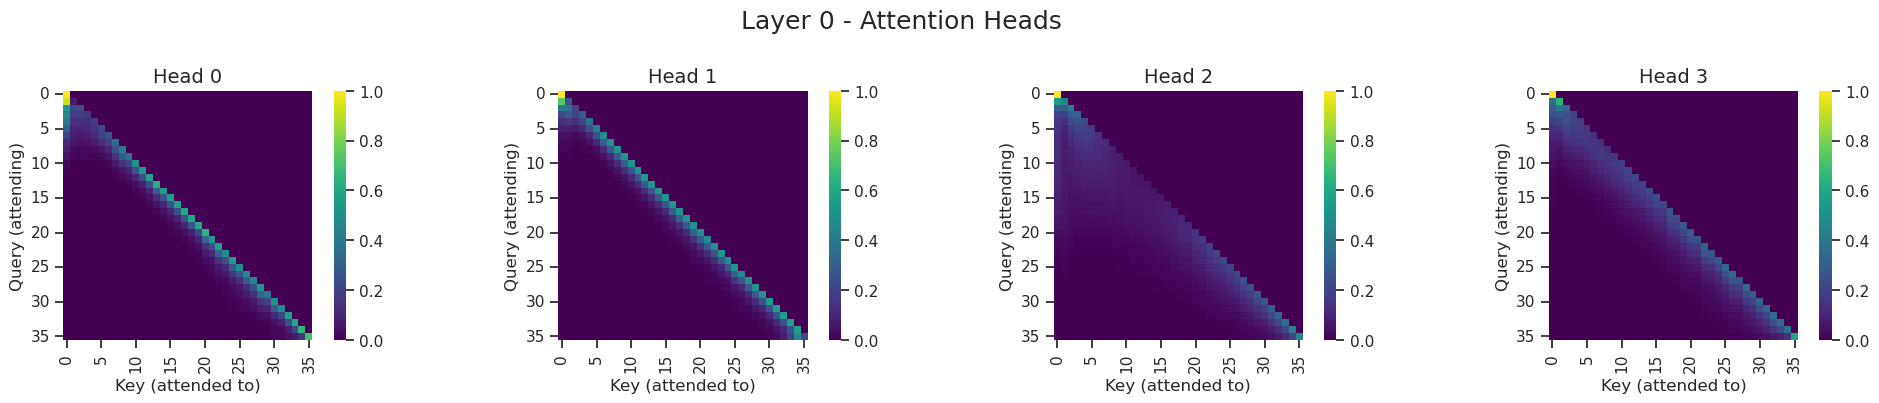


Viewing Layer 1 attention patterns:


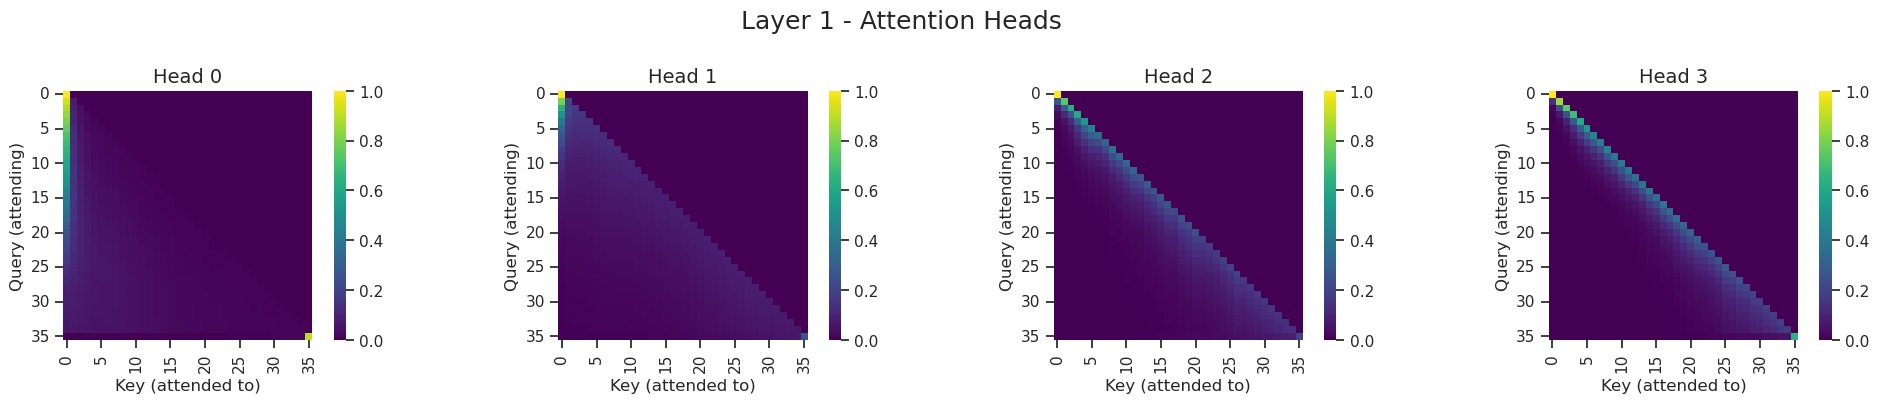


Viewing Layer 2 attention patterns:


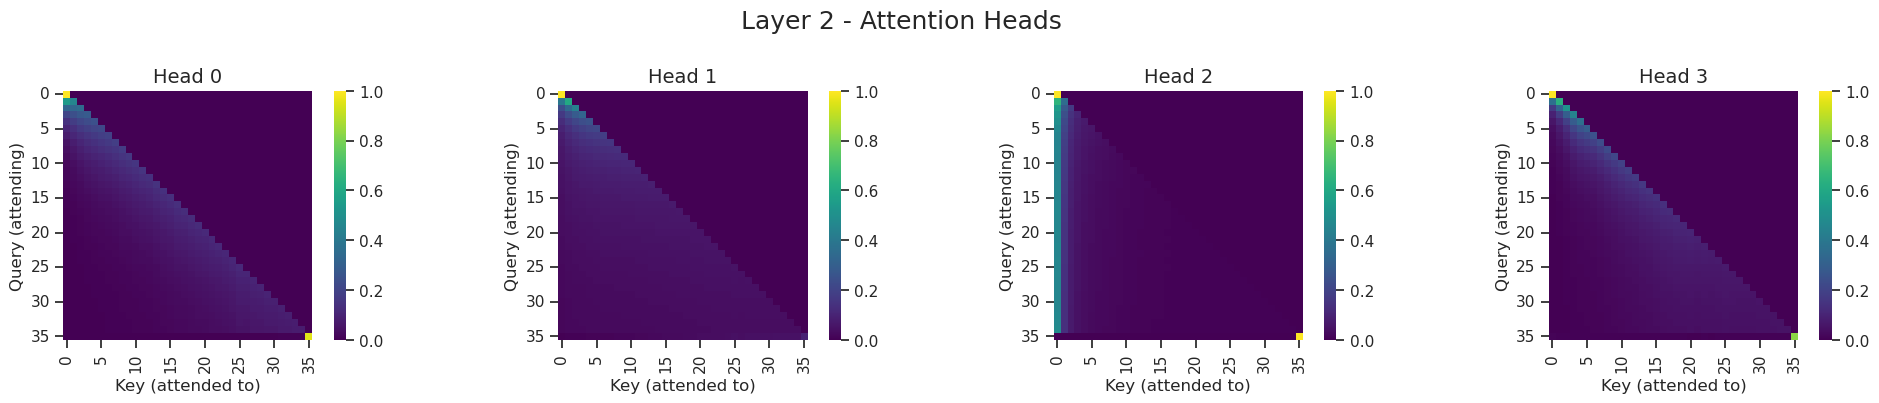


Viewing Layer 3 attention patterns:


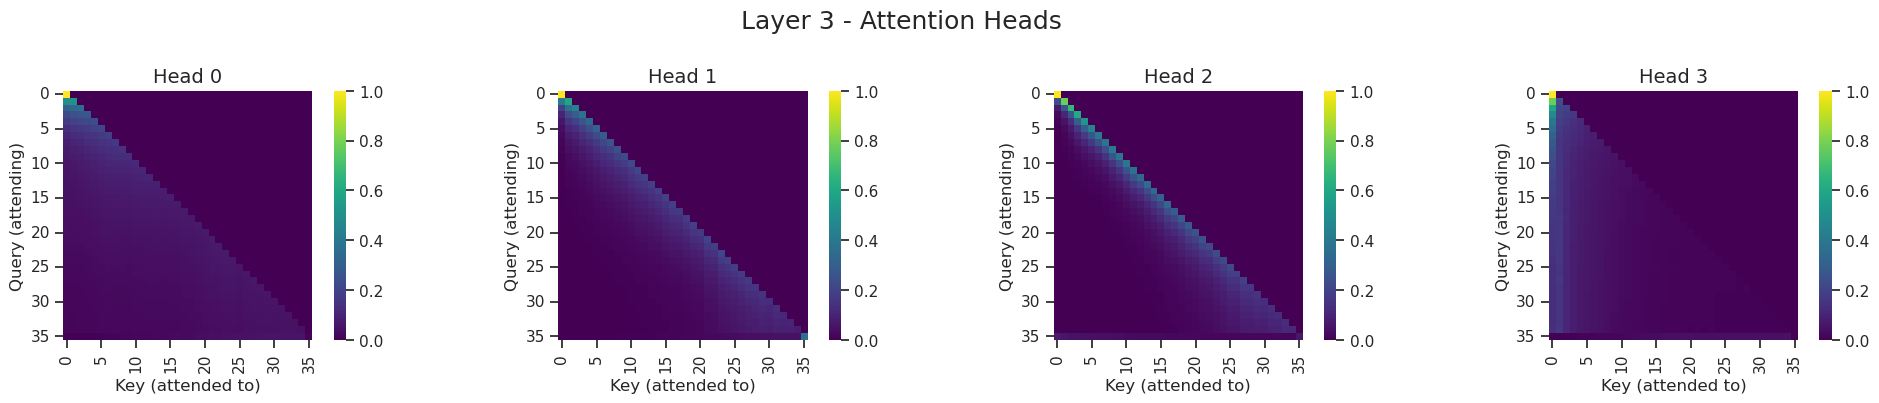


Analyzing sequence 5/5: LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Sequence: LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Predicted next token: L
Token probabilities: {'R': 0.005, 'r': 0.02, 'L': 0.853, 'l': 0.122}

Viewing Layer 0 attention patterns:


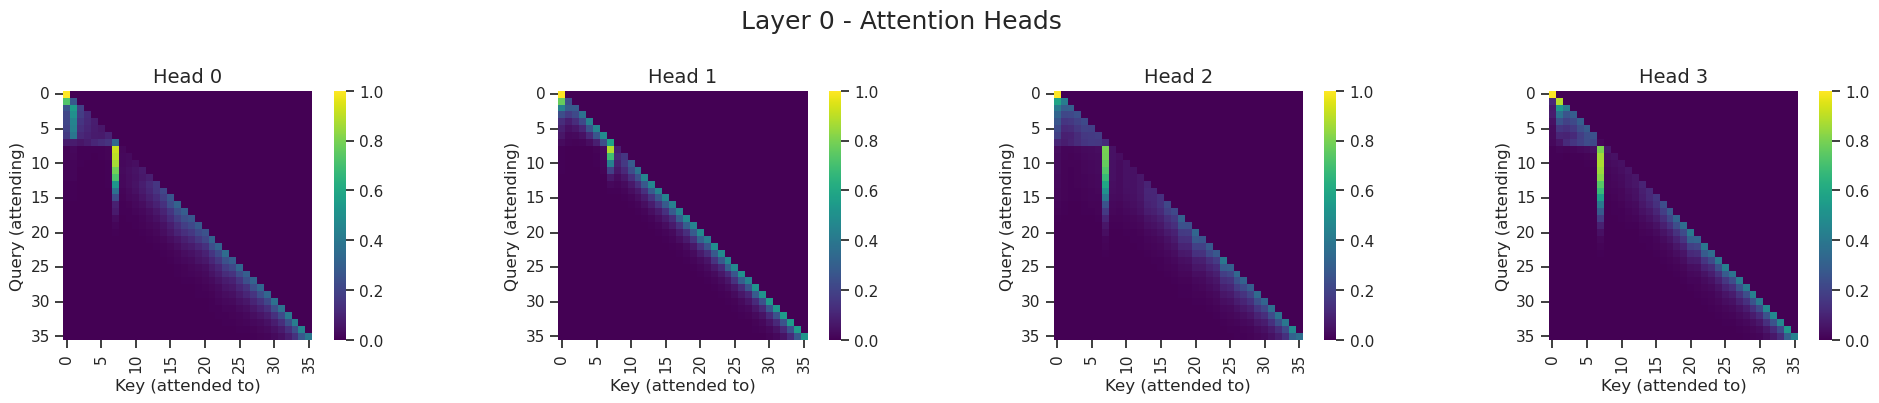


Viewing Layer 1 attention patterns:


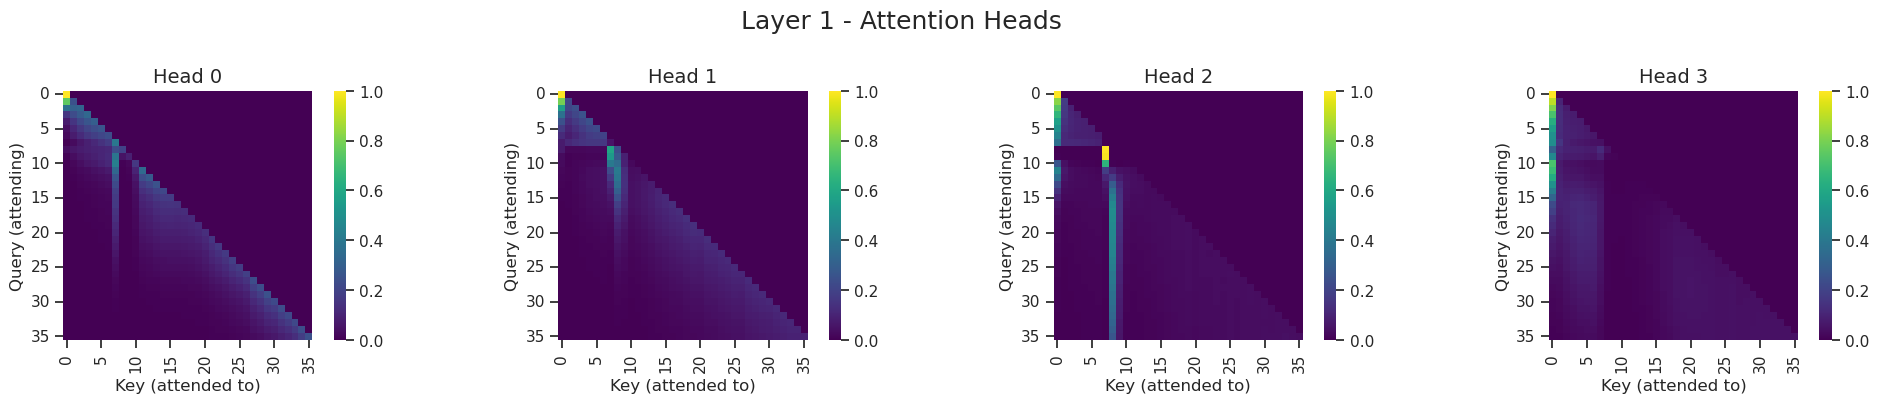


Viewing Layer 2 attention patterns:


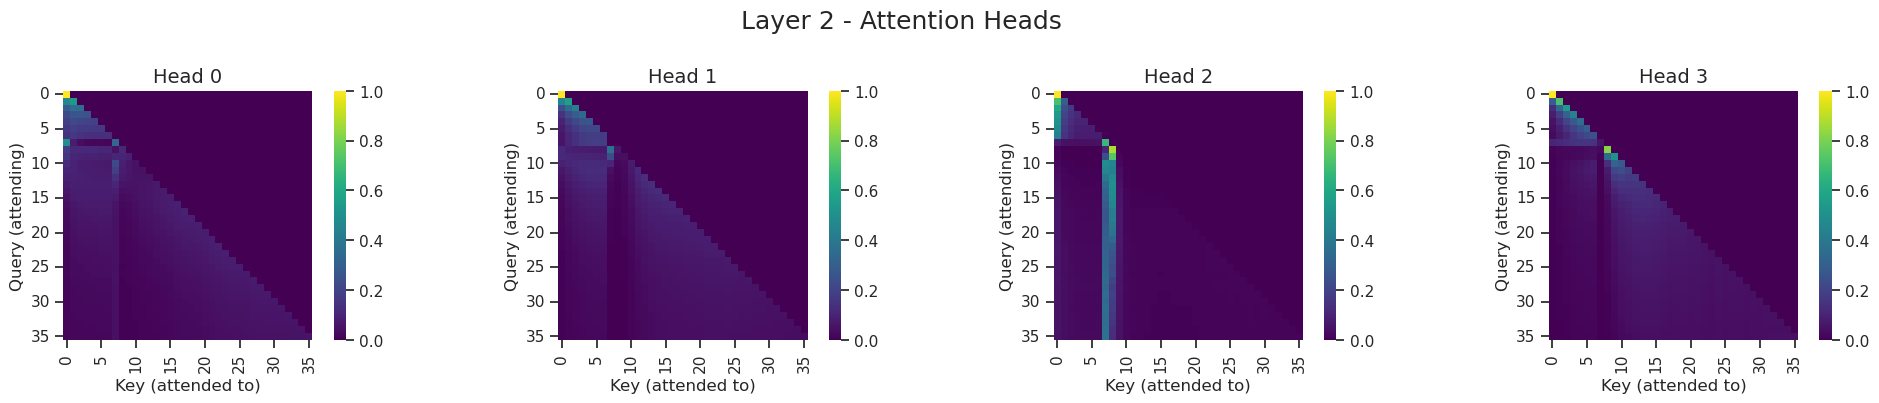


Viewing Layer 3 attention patterns:


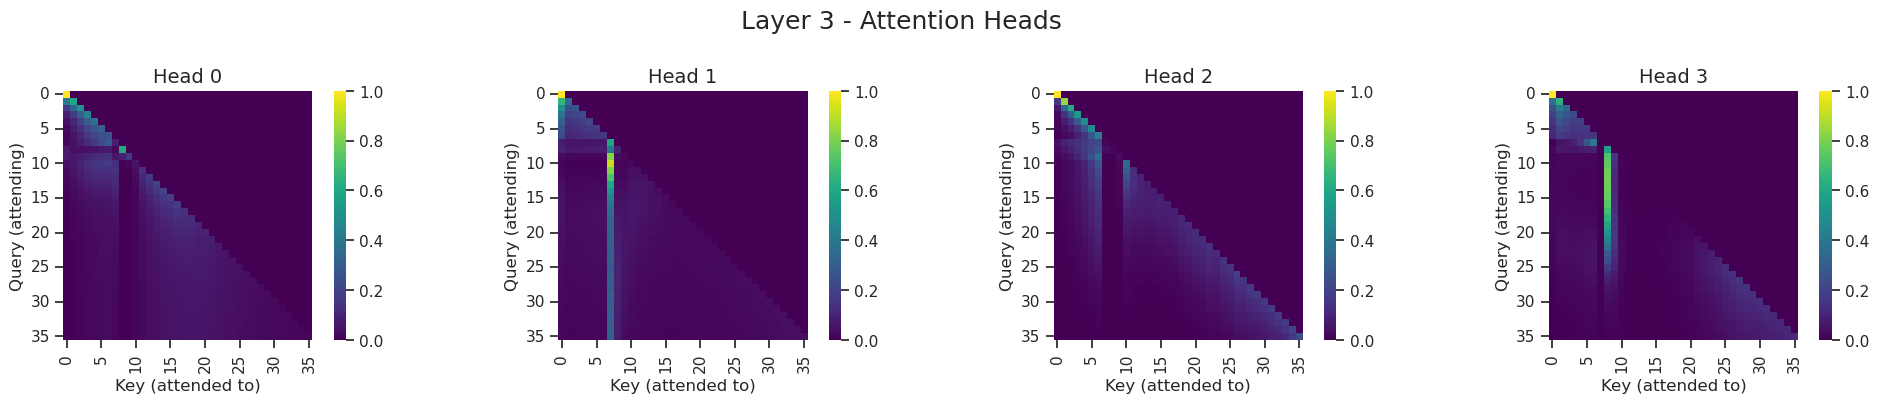

In [6]:
# def analyze_multiple_common_sequences():
#     """Analyze attention patterns for multiple common sequences"""
#     if len(common_sequences) > 0:
#         # Take up to 5 common sequences for analysis
#         sequences_to_analyze = common_sequences[:5]
        
#         for i, seq in enumerate(sequences_to_analyze):
#             print(f"\n{'='*50}")
#             print(f"Analyzing sequence {i+1}/{len(sequences_to_analyze)}: {seq}")
#             print(f"{'='*50}")
            
#             # Analyze first layer for each sequence
#             visualize_sequence_attention(seq, layer_idx=0)
            
#             # Add a small delay to prevent notebook output from being too crowded
#             plt.show()
#     else:
#         print("No common sequences found in the dataset.")
        
#         # Use predefined sequences instead
        
#         for i, seq in enumerate(sequences_to_analyze):
#             print(f"\n{'='*50}")
#             print(f"Analyzing sequence {i+1}/{len(sequences_to_analyze)}: {seq}")
#             print(f"{'='*50}")
            
#             # Analyze first layer for each sequence
#             visualize_sequence_attention(seq, layer_idx=0)
            
#             # Add a small delay to prevent notebook output from being too crowded
#             plt.show()

# # Run the analysis for multiple common sequences
# analyze_multiple_common_sequences()


# Longer version for model #2
def analyze_multiple_common_sequences():
    """Analyze attention patterns for multiple common sequences across all layers"""
    if len(common_sequences) > 0:
        # Take up to 5 common sequences for analysis
        sequences_to_analyze = common_sequences[:5]
        
        for i, seq in enumerate(sequences_to_analyze):
            print(f"\n{'='*50}")
            print(f"Analyzing sequence {i+1}/{len(sequences_to_analyze)}: {seq}")
            print(f"{'='*50}")
            
            # Encode the sequence
            input_ids = encode_sequence(seq, stoi)
            
            # Get attention maps
            attention_maps = get_attention_maps(model, input_ids)
            
            # Get next token prediction
            probs = predict_next_token(model, input_ids)
            next_token_pred = vocab[np.argmax(probs)]
            
            print(f"Sequence: {seq}")
            print(f"Predicted next token: {next_token_pred}")
            print(f"Token probabilities: {dict(zip(vocab, probs.round(3)))}")
            
            # Analyze all layers for each sequence
            num_layers = len(attention_maps)
            for layer in range(num_layers):
                print(f"\nViewing Layer {layer} attention patterns:")
                fig = plot_all_attention_heads(attention_maps[layer], seq, layer)
                plt.show()
    else:
        print("No common sequences found in the dataset.")
        # Define some default sequences if common_sequences is empty
        sequences_to_analyze = ["RLRL", "RRRR", "LLLL", "RLrl", "rlRL"]
        
        for i, seq in enumerate(sequences_to_analyze):
            print(f"\n{'='*50}")
            print(f"Analyzing sequence {i+1}/{len(sequences_to_analyze)}: {seq}")
            print(f"{'='*50}")
            
            # Encode the sequence
            input_ids = encode_sequence(seq, stoi)
            
            # Get attention maps
            attention_maps = get_attention_maps(model, input_ids)
            
            # Get next token prediction
            probs = predict_next_token(model, input_ids)
            next_token_pred = vocab[np.argmax(probs)]
            
            print(f"Sequence: {seq}")
            print(f"Predicted next token: {next_token_pred}")
            print(f"Token probabilities: {dict(zip(vocab, probs.round(3)))}")
            
            # Analyze all layers for each sequence
            num_layers = len(attention_maps)
            for layer in range(num_layers):
                print(f"\nViewing Layer {layer} attention patterns:")
                fig = plot_all_attention_heads(attention_maps[layer], seq, layer)
                plt.show()
analyze_multiple_common_sequences()

## 4. Understanding Different Attention Patterns

Sequence: RRRRRRRRRRRRRRRRRRLLLLLLLLLLLLLLLLLL → Predicted next token: L


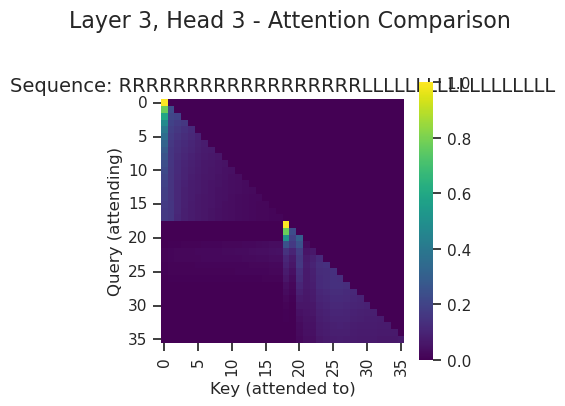

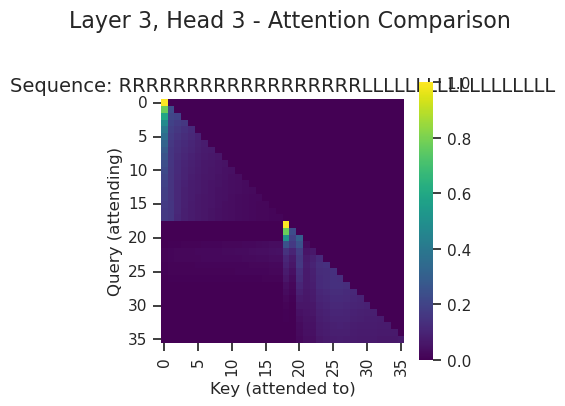

In [7]:
def compare_attention_for_sequences(sequences, layer_idx=3, head_idx=3):
    """Compare attention patterns for different sequences in the same head"""
    n_sequences = len(sequences)
    fig, axes = plt.subplots(1, n_sequences, figsize=(n_sequences*4, 4))
    
    for i, seq in enumerate(sequences):
        # Encode sequence
        input_ids = encode_sequence(seq, stoi)
        
        # Get attention maps
        attention_maps = get_attention_maps(model, input_ids)
        
        # Get attention for specified layer and head
        att_map = attention_maps[layer_idx]
        
        # Plot attention pattern
        ax = axes[i] if n_sequences > 1 else axes
        plot_attention_head(att_map, head_idx, seq, ax=ax, 
                            title=f'Sequence: {seq}')
        
        # Get prediction
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        print(f"Sequence: {seq} → Predicted next token: {next_token}")
    
    plt.suptitle(f'Layer {layer_idx}, Head {head_idx} - Attention Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig


# Add common sequences
sequences_to_compare = common_sequences
sequences_to_compare = sequences_to_compare[:5] 

sequences_to_compare = ["RRRRRRRRRRRRRRRRRRLLLLLLLLLLLLLLLLLL"]#custom
# Compare attention patterns
compare_attention_for_sequences(sequences_to_compare)


Interp: What’s interesting here. → Significant self attention. Because no changes the block is more or less monotonically decreasing in terms of attention sorted by recency. Note that this is the bottom room for the next prediction
What’s interesting here. → Pays attention to the misses, r, in a significant amount compared to the RRRRRR series. Cool
What’s significant here -> Small bump in the rRR second half since there is interesting behavior. Compared to the RRRRRR case


## 5. Analyzing How Attention Heads Specialize


Analyzing sequence 1/5: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL


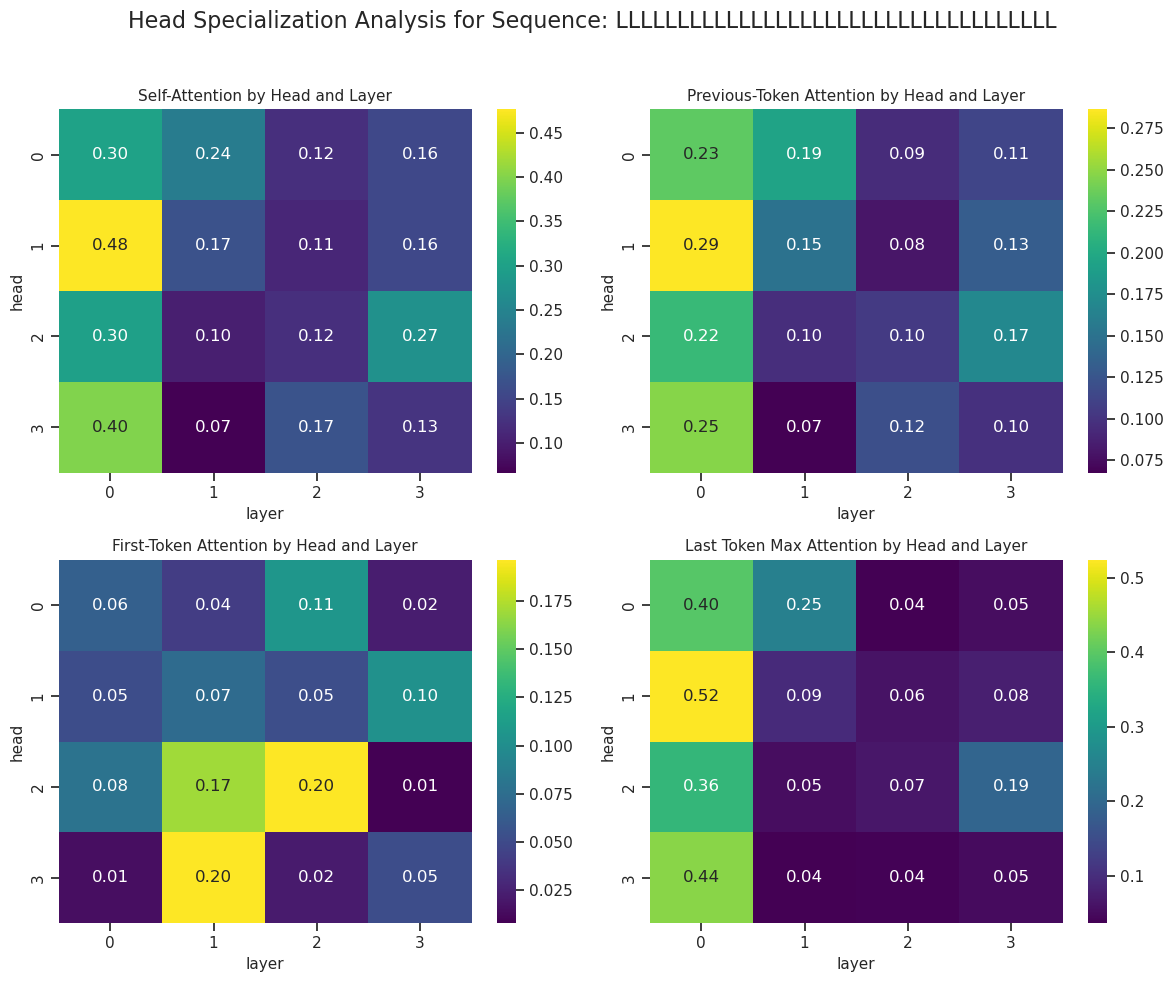


Top last-token attention patterns for sequence 'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL':
   layer  head  max_attention max_attention_pos attended_token
1      0     1       0.523986          (35, 35)              L
3      0     3       0.436610          (35, 35)              L
0      0     0       0.395101          (35, 35)              L
2      0     2       0.359413          (35, 35)              L
4      1     0       0.246738          (35, 35)              L

Analyzing sequence 2/5: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


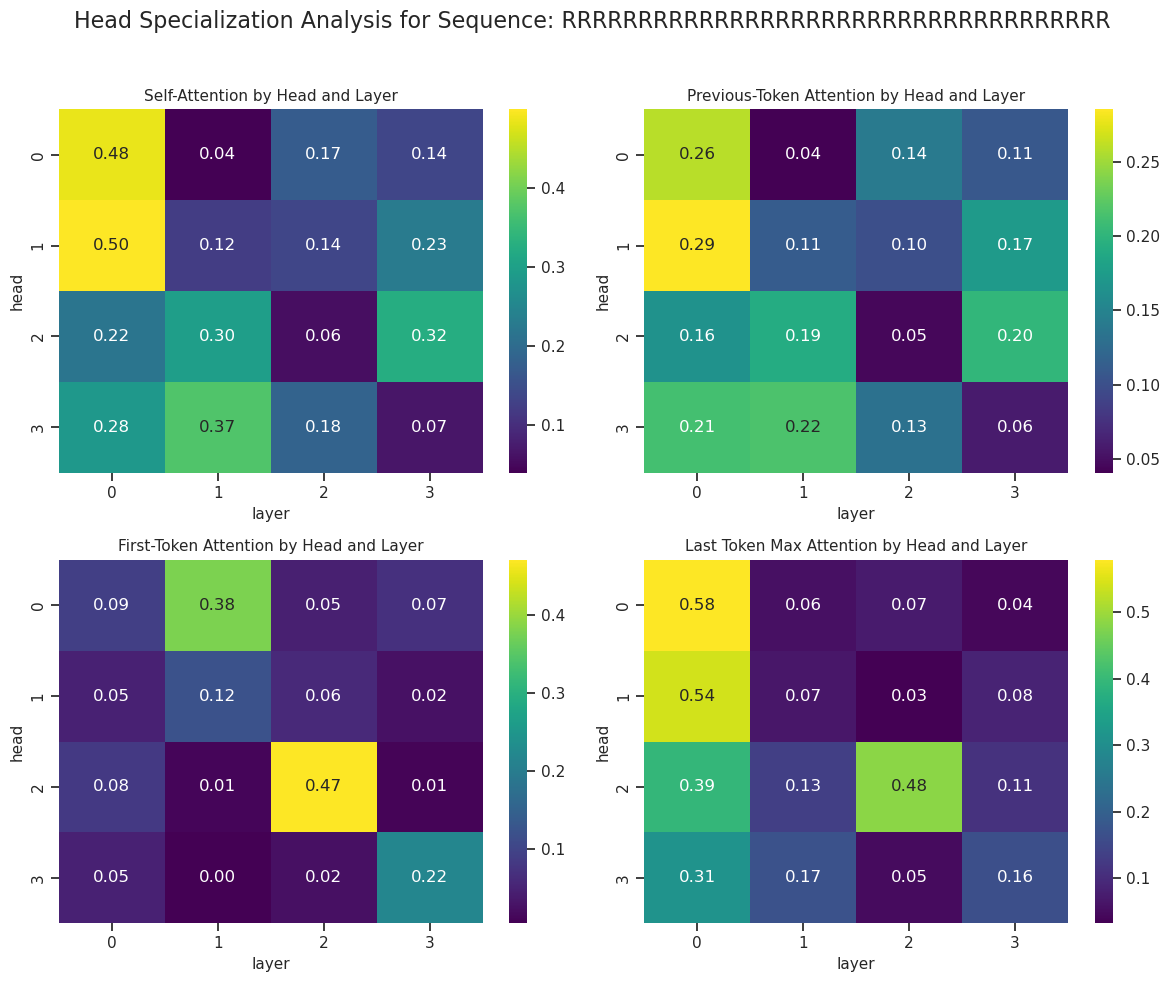


Top last-token attention patterns for sequence 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR':
    layer  head  max_attention max_attention_pos attended_token
0       0     0       0.578867          (35, 35)              R
1       0     1       0.541509          (35, 35)              R
10      2     2       0.483230           (35, 0)              R
2       0     2       0.394199          (35, 35)              R
3       0     3       0.312989          (35, 35)              R

Analyzing sequence 3/5: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl


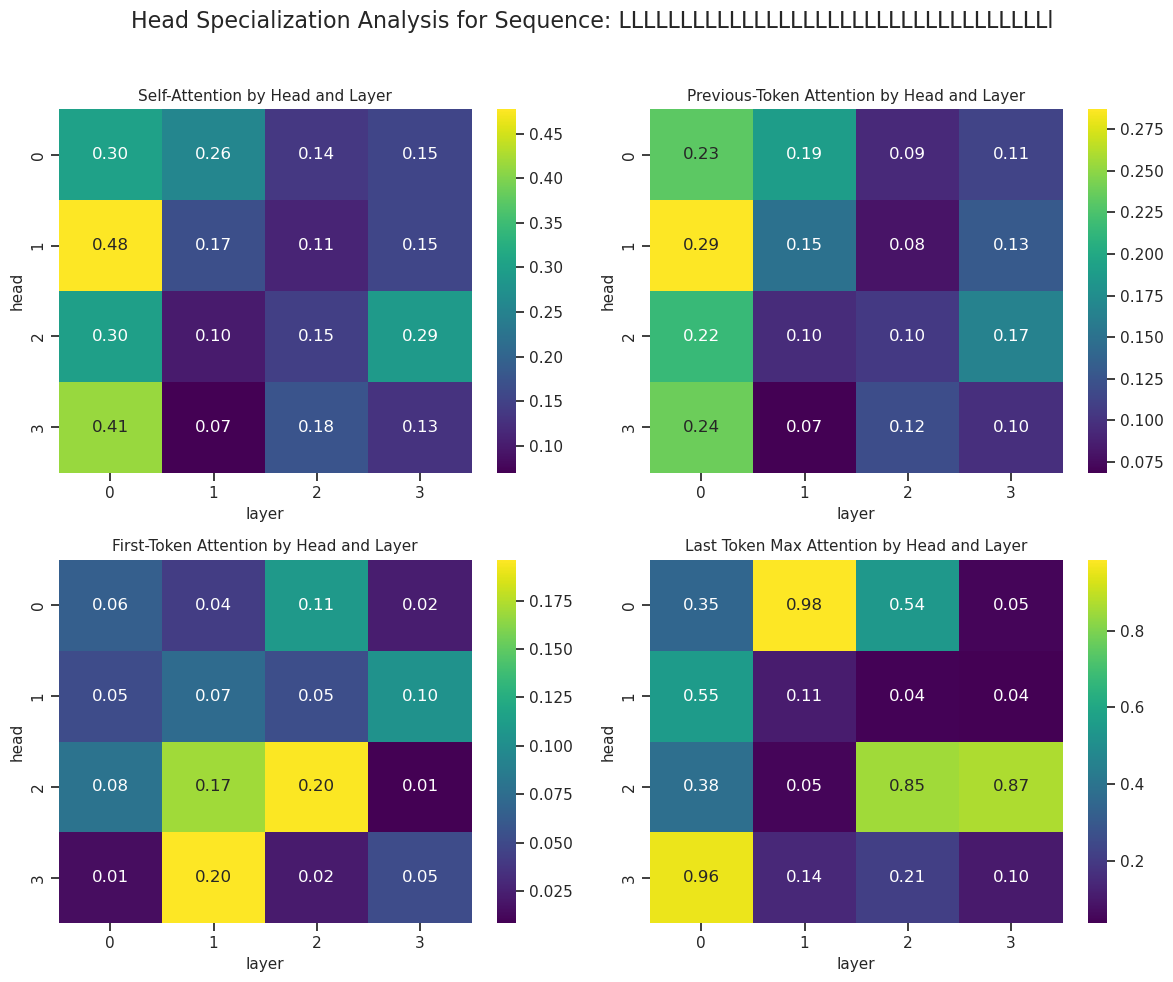


Top last-token attention patterns for sequence 'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl':
    layer  head  max_attention max_attention_pos attended_token
4       1     0       0.984736          (35, 35)              l
3       0     3       0.956394          (35, 35)              l
14      3     2       0.866747          (35, 35)              l
10      2     2       0.848177          (35, 35)              l
1       0     1       0.551991          (35, 35)              l

Analyzing sequence 4/5: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr


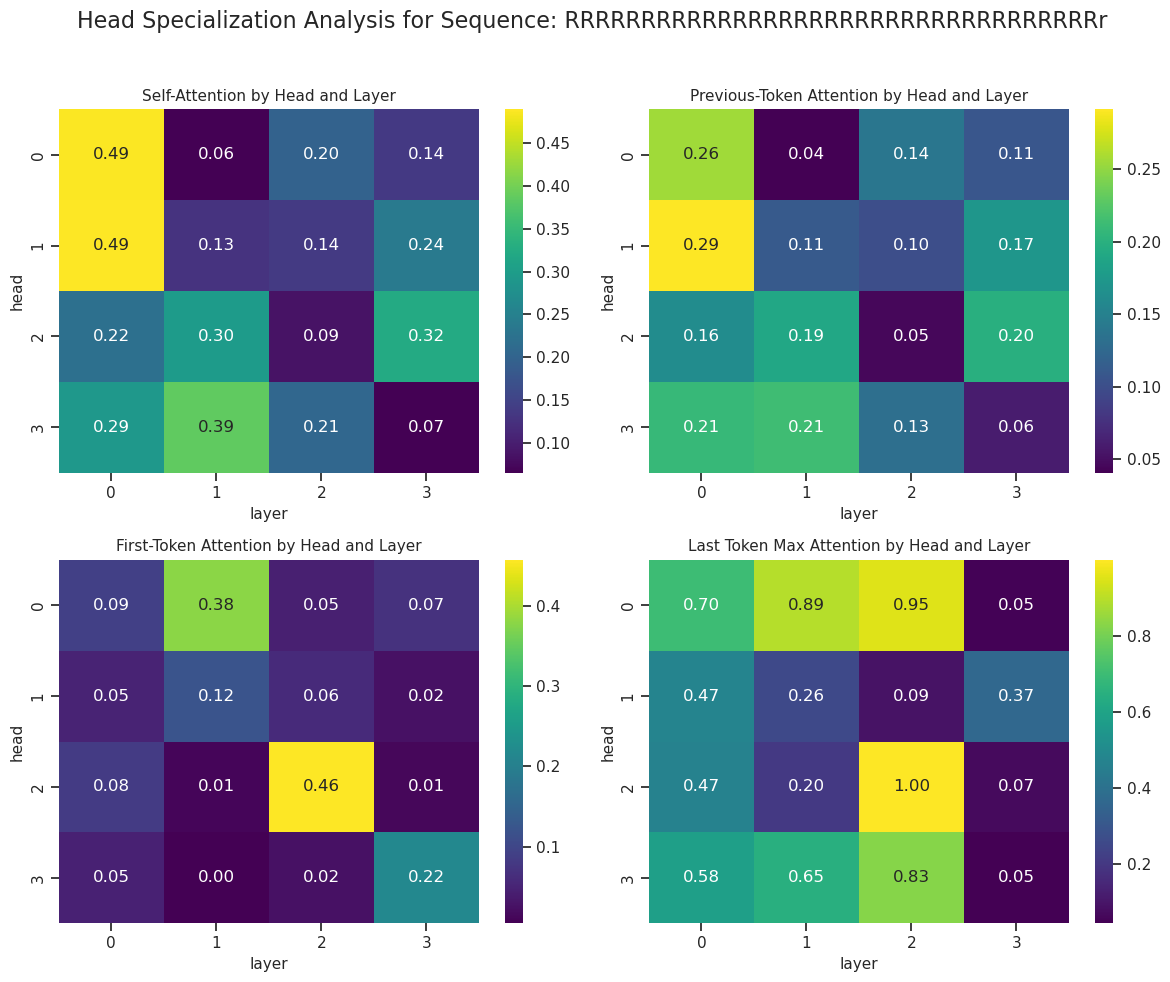


Top last-token attention patterns for sequence 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr':
    layer  head  max_attention max_attention_pos attended_token
10      2     2       0.999978          (35, 35)              r
8       2     0       0.954976          (35, 35)              r
4       1     0       0.892862          (35, 35)              r
11      2     3       0.825541          (35, 35)              r
0       0     0       0.698866          (35, 35)              r

Analyzing sequence 5/5: LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL


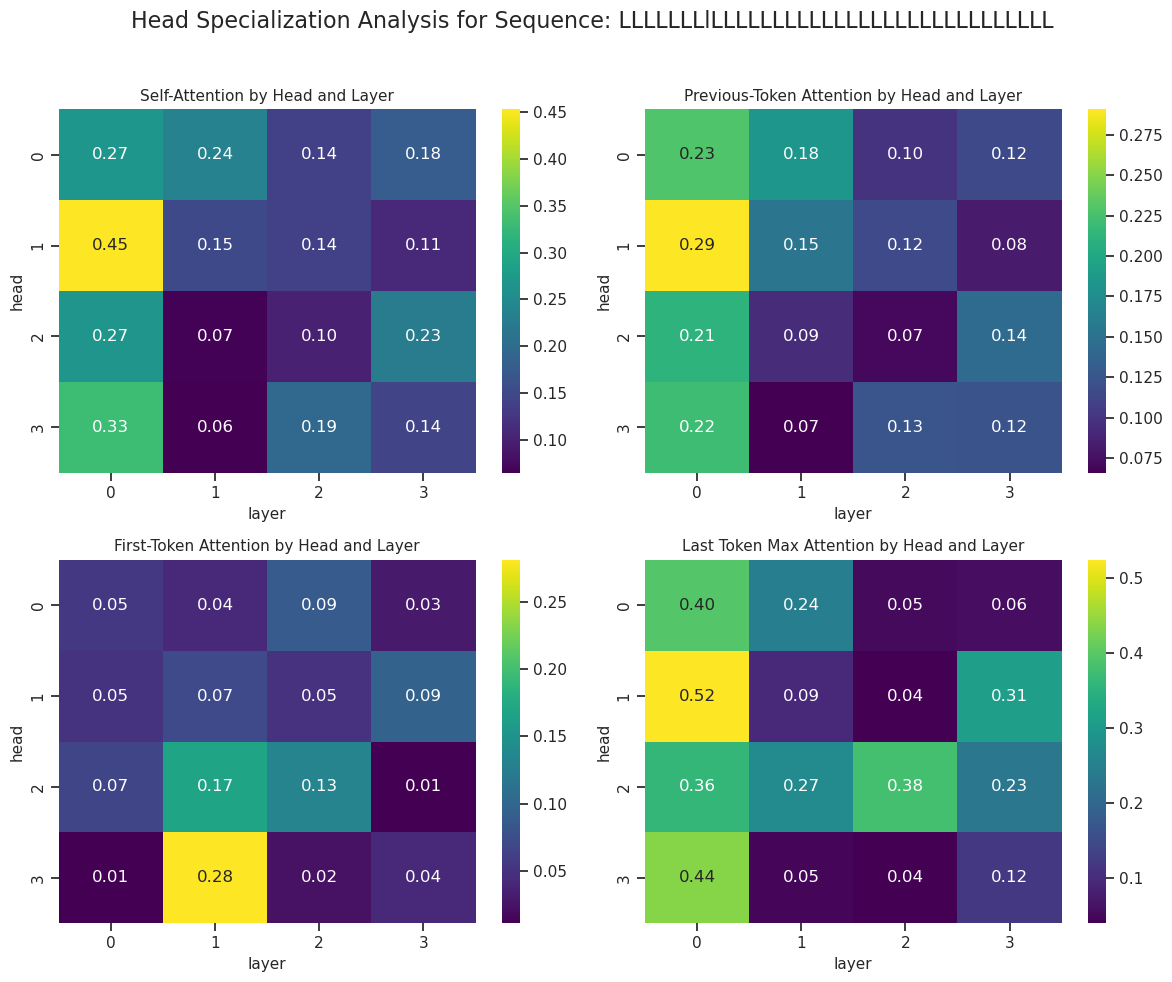


Top last-token attention patterns for sequence 'LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL':
    layer  head  max_attention max_attention_pos attended_token
1       0     1       0.523986          (35, 35)              L
3       0     3       0.436610          (35, 35)              L
0       0     0       0.395101          (35, 35)              L
10      2     2       0.379753           (35, 7)              l
2       0     2       0.359413          (35, 35)              L


In [8]:
def analyze_head_specialization(sequence):
    """Analyze how different heads specialize in different patterns"""
    # Encode the sequence
    input_ids = encode_sequence(sequence, stoi)
    
    # Get attention maps
    attention_maps = get_attention_maps(model, input_ids)
    
    # Analysis metrics for each head
    results = []
    
    for layer_idx, att_map in enumerate(attention_maps):
        n_heads = att_map.shape[1]
        
        for head_idx in range(n_heads):
            # Get attention matrix for this head
            att = att_map[0, head_idx]
            seq_len = len(sequence)
            
            # Calculate attention to self (diagonal)
            self_attention = np.mean(np.diag(att))
            
            # Calculate attention to previous token
            prev_attention = 0
            for i in range(1, len(sequence)):
                prev_attention += att[i, i-1]
            prev_attention /= (len(sequence) - 1) if len(sequence) > 1 else 1
            
            # Calculate attention to first token
            first_attention = np.mean(att[1:, 0]) if len(sequence) > 1 else 0
            
            # Focus on last token's attention (which informs next token prediction)
            last_token_attention = att[seq_len-1, :seq_len]  # Bottom row
            
            # Calculate maximum attention from last token
            max_attention = np.max(last_token_attention)
            max_pos = np.argmax(last_token_attention)
            max_attention_pos = (seq_len-1, max_pos)  # Last token attending to position max_pos
            
            # Store results
            results.append({
                'layer': layer_idx,
                'head': head_idx,
                'self_attention': self_attention,
                'prev_attention': prev_attention,
                'first_attention': first_attention,
                'max_attention': max_attention,
                'max_attention_pos': max_attention_pos,
                'attended_token': sequence[max_pos]  # Which token is being attended to
            })
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # Plot the specialization patterns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Head Specialization Analysis for Sequence: {sequence}', fontsize=16)
    
    # Plot self-attention by head/layer
    pivot_self = df.pivot(index='head', columns='layer', values='self_attention')
    sns.heatmap(pivot_self, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Self-Attention by Head and Layer')
    
    # Plot prev-token attention by head/layer
    pivot_prev = df.pivot(index='head', columns='layer', values='prev_attention')
    sns.heatmap(pivot_prev, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 1])
    axes[0, 1].set_title('Previous-Token Attention by Head and Layer')
    
    # Plot first-token attention by head/layer
    pivot_first = df.pivot(index='head', columns='layer', values='first_attention')
    sns.heatmap(pivot_first, annot=True, fmt='.2f', cmap='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('First-Token Attention by Head and Layer')
    
    # Plot max attention by head/layer (from last token only)
    pivot_max = df.pivot(index='head', columns='layer', values='max_attention')
    sns.heatmap(pivot_max, annot=True, fmt='.2f', cmap='viridis', ax=axes[1, 1])
    axes[1, 1].set_title('Last Token Max Attention by Head and Layer')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig, df

# Show the specialization data
top_sequences = common_sequences[:5]
for i, sequence in enumerate(top_sequences):
    print(f"\n==================================================")
    print(f"Analyzing sequence {i+1}/5: {sequence}")
    print(f"==================================================")
    fig, df = analyze_head_specialization(sequence)
    plt.show()
    
    # Display the top specialization patterns, showing which token is attended to
    print(f"\nTop last-token attention patterns for sequence '{sequence}':")
    print(df.sort_values('max_attention', ascending=False).head(5)[['layer', 'head', 'max_attention', 'max_attention_pos', 'attended_token']])

## 6. How Attention Patterns relate to the Decisions


Analyzing attention patterns for sequences predicting 'L'
Number of sequences: 25
Example sequences: ['LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL', 'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl', 'LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL']


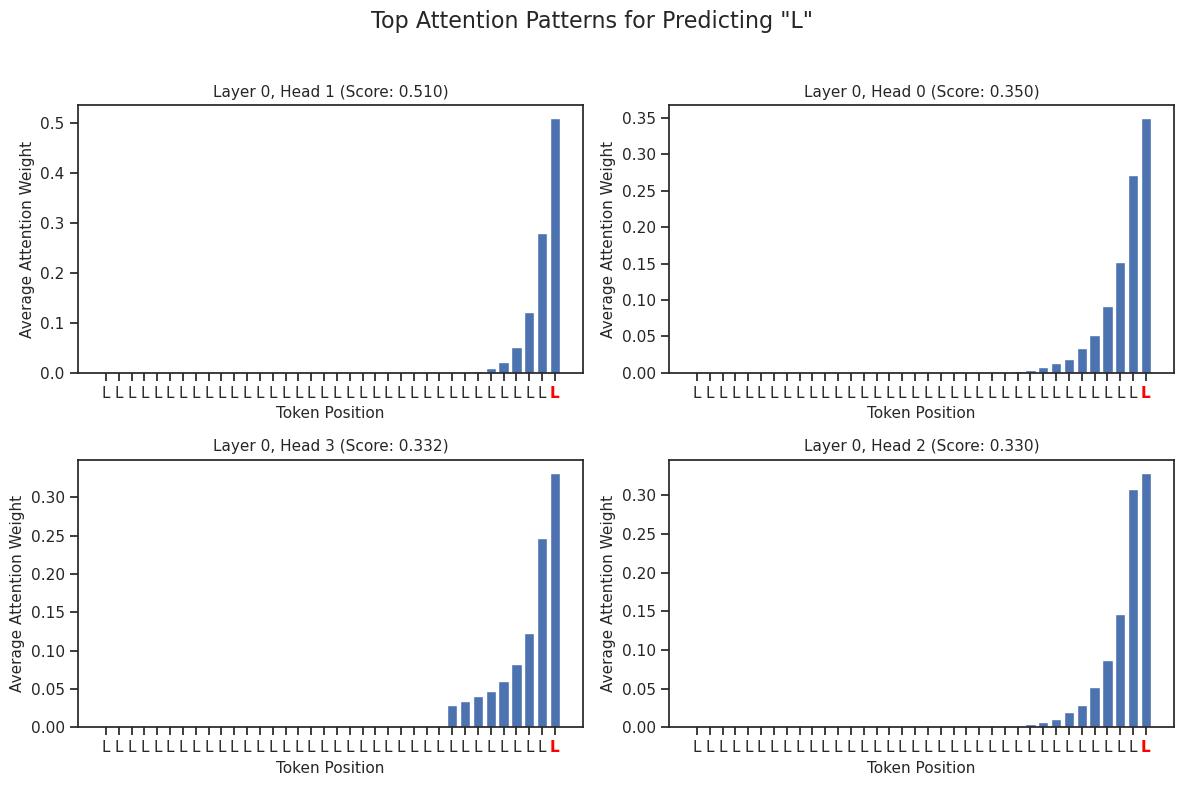


Analyzing attention patterns for sequences predicting 'R'
Number of sequences: 5
Example sequences: ['RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr', 'RRRRRRRRRRrRRRRRRRRRRRRRRRRRRRRRRRRR']


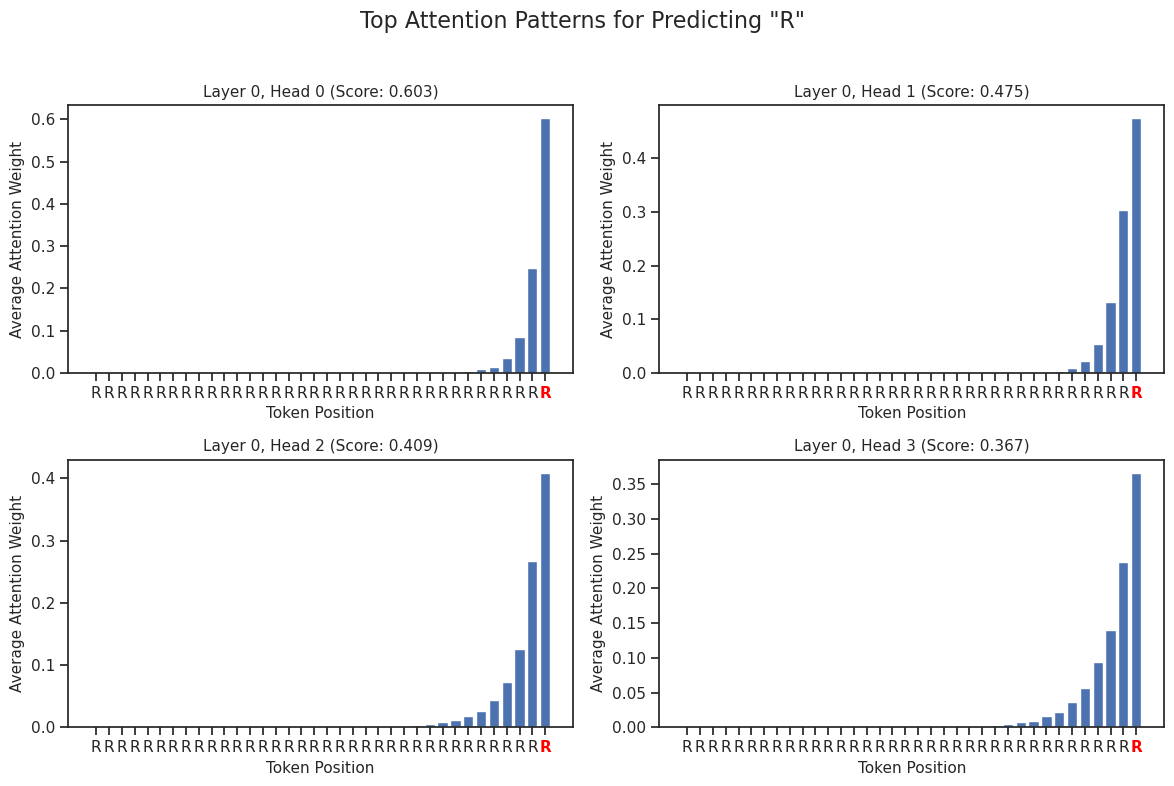


Most influential head/layer combinations for each decision outcome:

For predicting 'L':
   layer  head  max_attention  attended_position
1      0     1       0.509826                 35
0      0     0       0.349716                 35
3      0     3       0.332092                 35

For predicting 'R':
    layer  head  max_attention  attended_position
16      0     0       0.602867                 35
17      0     1       0.475201                 35
18      0     2       0.409195                 35


In [9]:

def analyze_decision_making(sequences):
    """Analyze how attention patterns relate to decision outcomes"""
    # Group sequences by their next predicted token
    predictions = {}
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        if next_token not in predictions:
            predictions[next_token] = []
        
        predictions[next_token].append({
            'sequence': seq,
            'attention_maps': get_attention_maps(model, input_ids),
            'probs': probs
        })
    
    # For each decision outcome, analyze common attention patterns
    results = []
    
    for next_token, sequences in predictions.items():
        print(f"\nAnalyzing attention patterns for sequences predicting '{next_token}'")
        print(f"Number of sequences: {len(sequences)}")
        print(f"Example sequences: {[s['sequence'] for s in sequences[:3]]}")
        
        
        # Calculate average attention for last token (the one before prediction)
        avg_last_token_attention = np.zeros((config.n_layer, config.n_head, len(sequences[0]['sequence'])))
        
        for seq_data in sequences:
            seq_len = len(seq_data['sequence'])
            
            for l in range(config.n_layer):
                for h in range(config.n_head):
                    # Get attention pattern for last token (which determines next prediction)
                    last_token_attention = seq_data['attention_maps'][l][0, h, seq_len-1, :seq_len]
                    avg_last_token_attention[l, h, :seq_len] += last_token_attention
        
        # Average across all sequences with this prediction
        avg_last_token_attention /= len(sequences)
        
        # Find most influential heads/layers for this decision
        for l in range(config.n_layer):
            for h in range(config.n_head):
                # Get max attention and its position
                max_att = np.max(avg_last_token_attention[l, h])
                max_pos = np.argmax(avg_last_token_attention[l, h])
                
                results.append({
                    'next_token': next_token,
                    'layer': l,
                    'head': h,
                    'max_attention': max_att,
                    'attended_position': max_pos,
                    'attended_tokens': [s['sequence'][max_pos] for s in sequences[:5] if max_pos < len(s['sequence'])]
                })
        
        # Visualize average attention for top heads
        top_combinations = sorted(
            [(l, h, np.max(avg_last_token_attention[l, h])) for l in range(config.n_layer) for h in range(config.n_head)],
            key=lambda x: x[2], reverse=True
        )[:4]  # Top 4 head/layer combinations
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        
        for i, (l, h, score) in enumerate(top_combinations[:4]):
            if i < len(axes):
                # Example sequence for visualization
                example_seq = sequences[0]['sequence']
                
                # Plot average attention pattern
                att_pattern = avg_last_token_attention[l, h, :len(example_seq)]
                ax = axes[i]
                ax.bar(range(len(example_seq)), att_pattern)
                ax.set_xticks(range(len(example_seq)))
                ax.set_xticklabels(list(example_seq))
                ax.set_title(f'Layer {l}, Head {h} (Score: {score:.3f})')
                ax.set_xlabel('Token Position')
                ax.set_ylabel('Average Attention Weight')
                
                # Highlight the max attention position
                max_pos = np.argmax(att_pattern)
                ax.get_xticklabels()[max_pos].set_color('red')
                ax.get_xticklabels()[max_pos].set_fontweight('bold')
        
        plt.suptitle(f'Top Attention Patterns for Predicting "{next_token}"', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    
    # Convert results to DataFrame for analysis
    df_results = pd.DataFrame(results)
    
    return df_results

# Get a set of sequences for analysis
analysis_sequences = vc[vc > 50].index.tolist()[:30]  # Top 10 common sequences

# Run the analysis
decision_analysis = analyze_decision_making(analysis_sequences)

# Show summary of results
print("\nMost influential head/layer combinations for each decision outcome:")
for token in sorted(decision_analysis['next_token'].unique()):
    token_df = decision_analysis[decision_analysis['next_token'] == token].sort_values('max_attention', ascending=False)
    top_combinations = token_df[['layer', 'head', 'max_attention', 'attended_position']].head(3)
    print(f"\nFor predicting '{token}':")
    print(top_combinations)


Analyzing attention patterns for sequences predicting 'L'
Number of sequences: 25
Example sequences: ['LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL', 'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLl', 'LLLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLL']

Layer 0 attention patterns for predicting 'L':


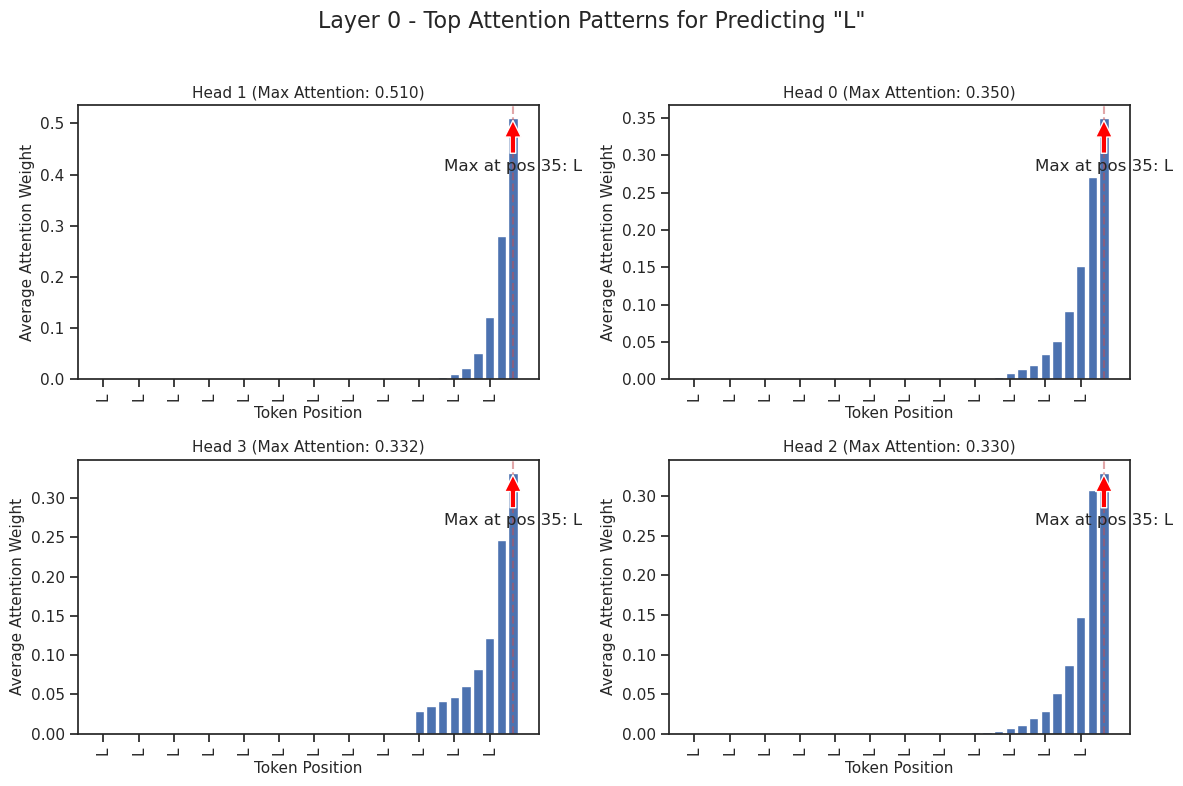

Top heads in Layer 0:
   head  max_attention  attended_position
0     1       0.509826                 35
1     0       0.349716                 35
2     3       0.332092                 35
3     2       0.329645                 35

Layer 1 attention patterns for predicting 'L':


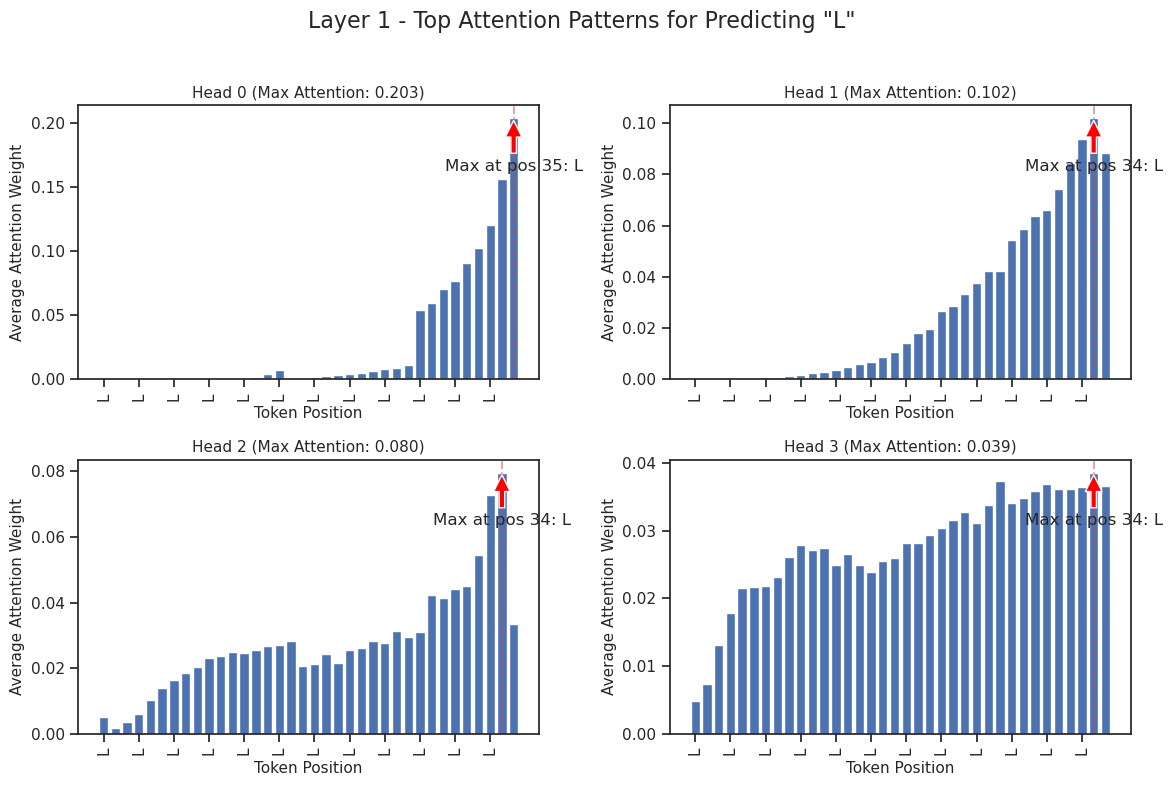

Top heads in Layer 1:
   head  max_attention  attended_position
0     0       0.203212                 35
1     1       0.101818                 34
2     2       0.079515                 34
3     3       0.038545                 34

Layer 2 attention patterns for predicting 'L':


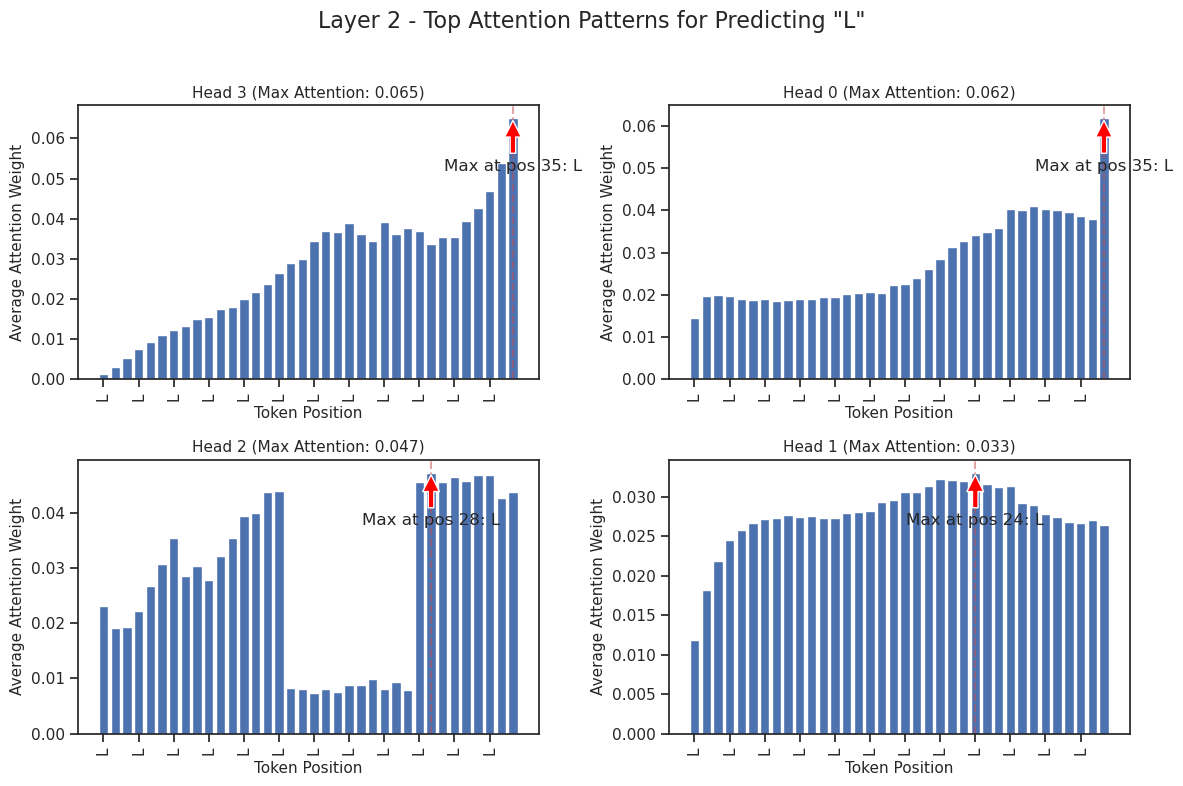

Top heads in Layer 2:
   head  max_attention  attended_position
0     3       0.064975                 35
1     0       0.061834                 35
2     2       0.047167                 28
3     1       0.033005                 24

Layer 3 attention patterns for predicting 'L':


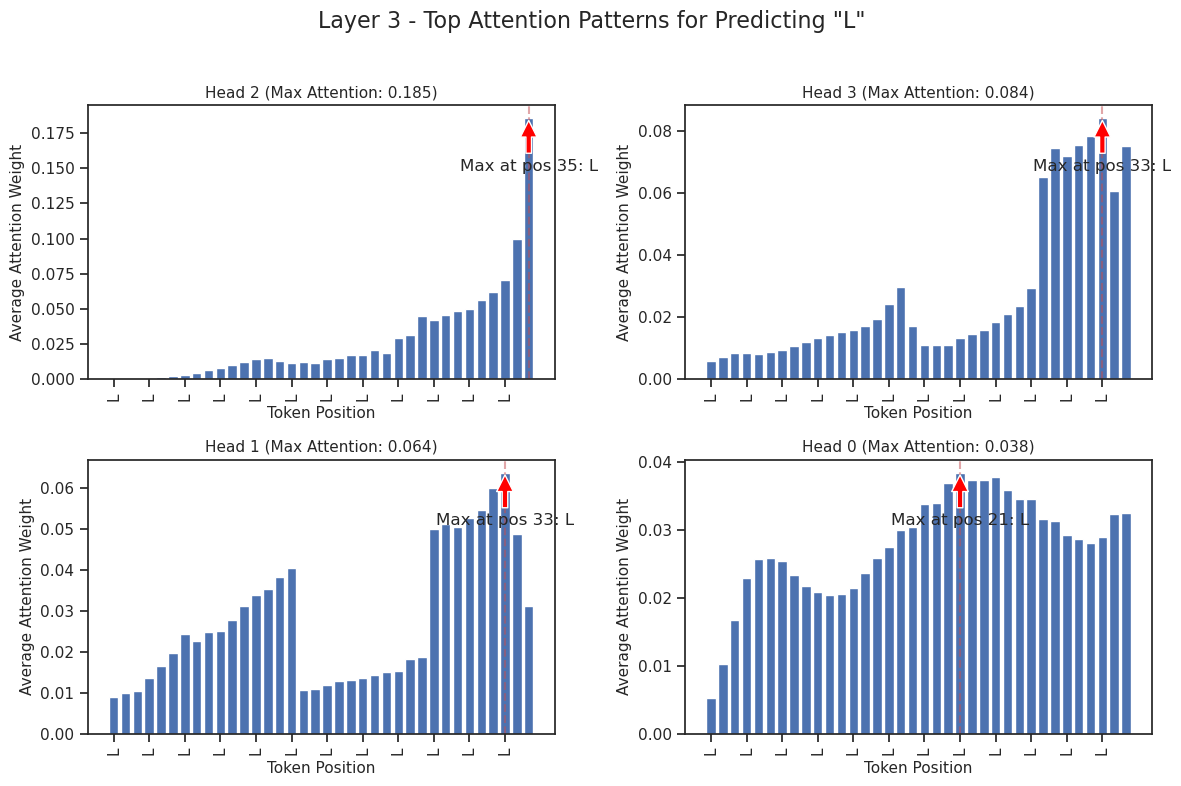

Top heads in Layer 3:
   head  max_attention  attended_position
0     2       0.185468                 35
1     3       0.084050                 33
2     1       0.063667                 33
3     0       0.038338                 21

Analyzing attention patterns for sequences predicting 'R'
Number of sequences: 5
Example sequences: ['RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr', 'RRRRRRRRRRrRRRRRRRRRRRRRRRRRRRRRRRRR']

Layer 0 attention patterns for predicting 'R':


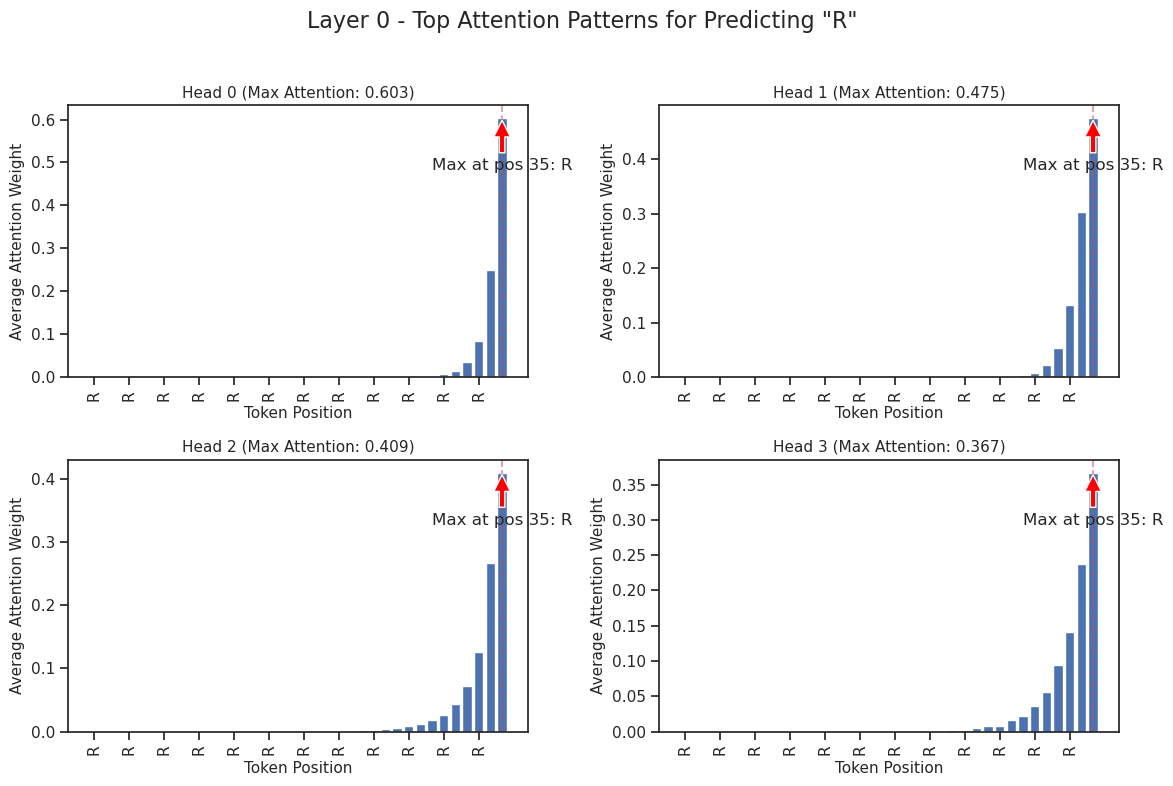

Top heads in Layer 0:
   head  max_attention  attended_position
0     0       0.602867                 35
1     1       0.475201                 35
2     2       0.409195                 35
3     3       0.366772                 35

Layer 1 attention patterns for predicting 'R':


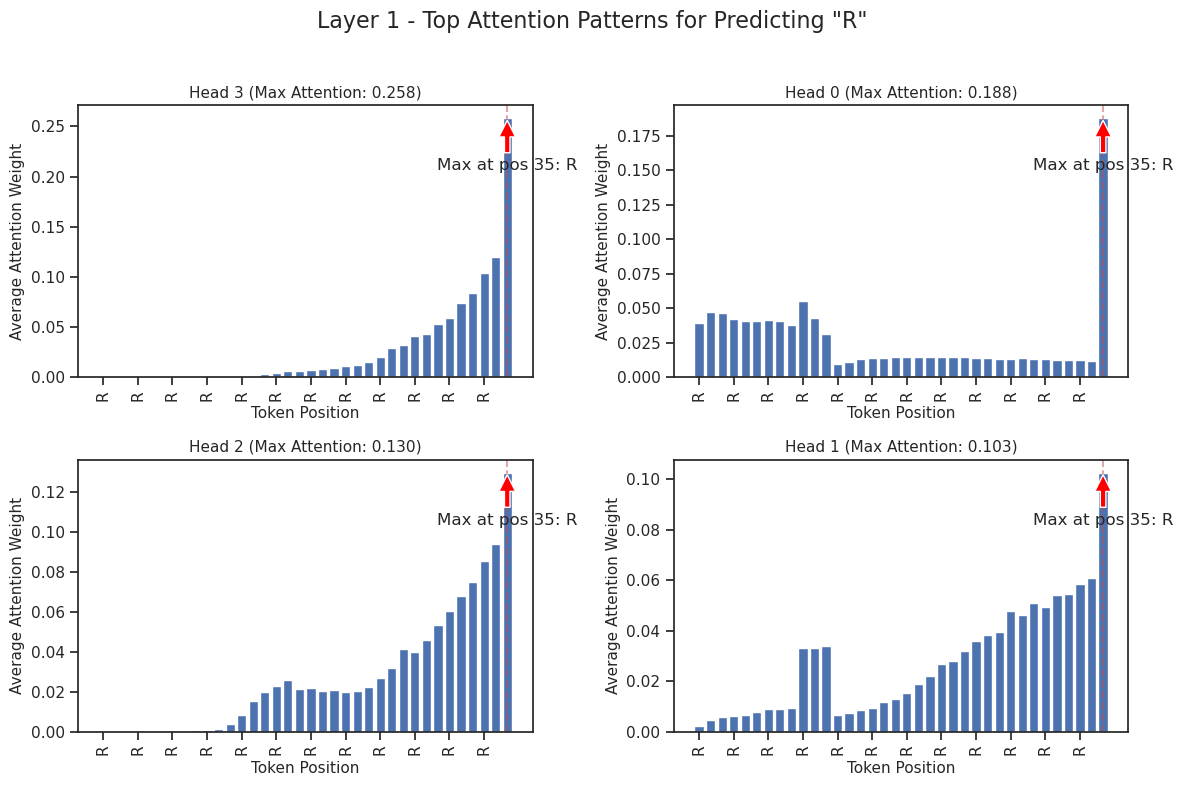

Top heads in Layer 1:
   head  max_attention  attended_position
0     3       0.258160                 35
1     0       0.187544                 35
2     2       0.129656                 35
3     1       0.102636                 35

Layer 2 attention patterns for predicting 'R':


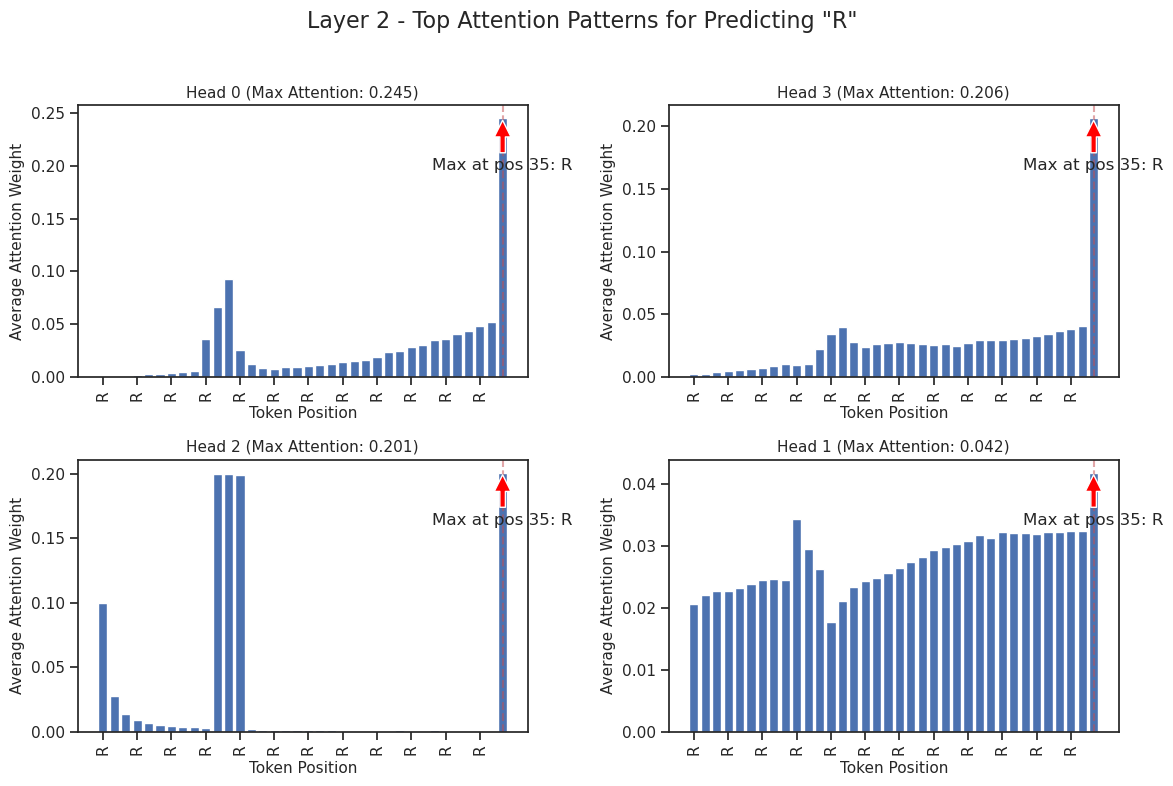

Top heads in Layer 2:
   head  max_attention  attended_position
0     0       0.244816                 35
1     3       0.206399                 35
2     2       0.200806                 35
3     1       0.041770                 35

Layer 3 attention patterns for predicting 'R':


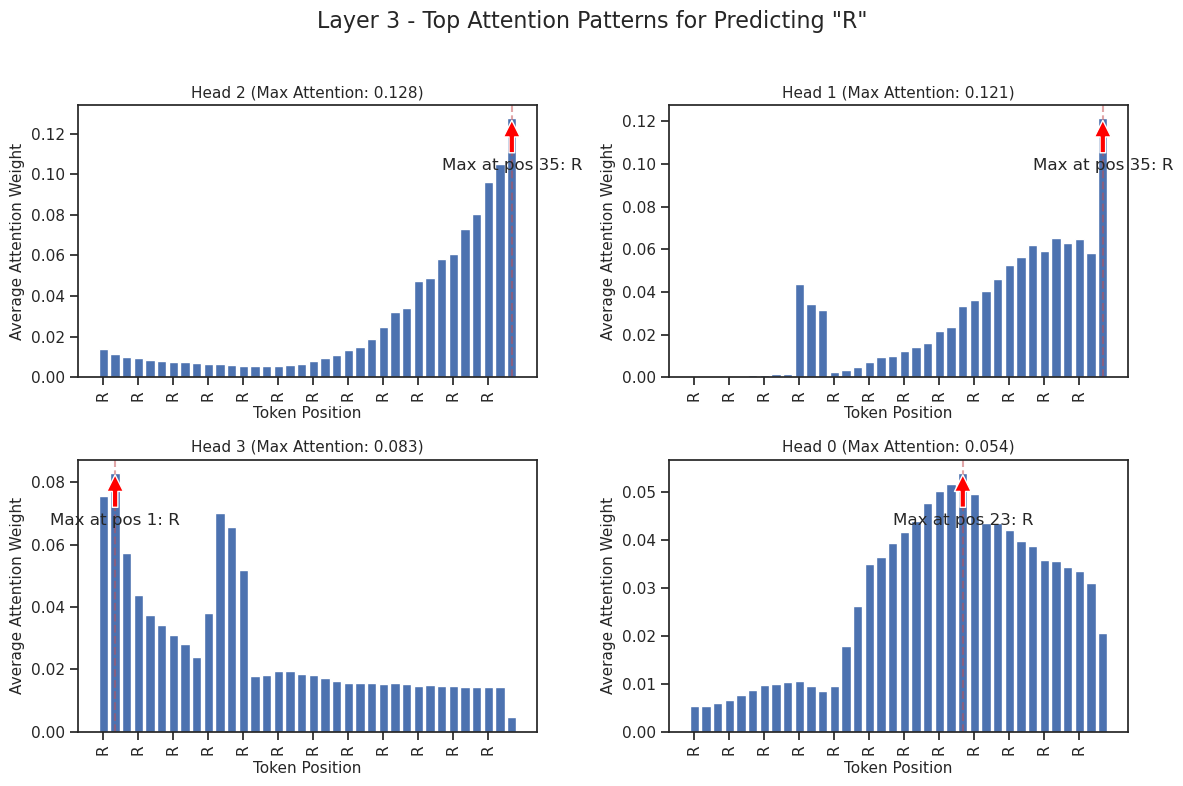

Top heads in Layer 3:
   head  max_attention  attended_position
0     2       0.127519                 35
1     1       0.121490                 35
2     3       0.083109                  1
3     0       0.053997                 23

Most influential head/layer combinations for each decision outcome:

For predicting 'L':
Top combinations across all layers:
   layer  head  max_attention  attended_position
1      0     1       0.509826                 35
0      0     0       0.349716                 35
3      0     3       0.332092                 35
2      0     2       0.329645                 35
4      1     0       0.203212                 35

Layer 0 top combinations:
   layer  head  max_attention  attended_position
1      0     1       0.509826                 35
0      0     0       0.349716                 35
3      0     3       0.332092                 35

Layer 1 top combinations:
   layer  head  max_attention  attended_position
4      1     0       0.203212                 35


In [10]:
#Version for larger model with 4 layers
def analyze_decision_making(sequences):
    """Analyze how attention patterns relate to decision outcomes for all layers"""
    # Group sequences by their next predicted token
    predictions = {}
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        if next_token not in predictions:
            predictions[next_token] = []
        
        predictions[next_token].append({
            'sequence': seq,
            'attention_maps': get_attention_maps(model, input_ids),
            'probs': probs
        })
    
    # For each decision outcome, analyze common attention patterns
    results = []
    
    for next_token, sequences in predictions.items():
        print(f"\n{'='*50}")
        print(f"Analyzing attention patterns for sequences predicting '{next_token}'")
        print(f"Number of sequences: {len(sequences)}")
        print(f"Example sequences: {[s['sequence'] for s in sequences[:3]]}")
        print(f"{'='*50}")
        
        # Calculate average attention for last token (the one before prediction)
        avg_last_token_attention = np.zeros((config.n_layer, config.n_head, len(sequences[0]['sequence'])))
        
        for seq_data in sequences:
            seq_len = len(seq_data['sequence'])
            
            for l in range(config.n_layer):
                for h in range(config.n_head):
                    # Get attention pattern for last token (which determines next prediction)
                    last_token_attention = seq_data['attention_maps'][l][0, h, seq_len-1, :seq_len]
                    avg_last_token_attention[l, h, :seq_len] += last_token_attention
        
        # Average across all sequences with this prediction
        avg_last_token_attention /= len(sequences)
        
        # Find most influential heads/layers for this decision
        for l in range(config.n_layer):
            for h in range(config.n_head):
                # Get max attention and its position
                max_att = np.max(avg_last_token_attention[l, h])
                max_pos = np.argmax(avg_last_token_attention[l, h])
                
                results.append({
                    'next_token': next_token,
                    'layer': l,
                    'head': h,
                    'max_attention': max_att,
                    'attended_position': max_pos,
                    'attended_tokens': [s['sequence'][max_pos] for s in sequences[:5] if max_pos < len(s['sequence'])]
                })
        
        # Create a separate visualization for each layer
        for layer_idx in range(config.n_layer):
            print(f"\nLayer {layer_idx} attention patterns for predicting '{next_token}':")
            
            # Find top heads in this layer
            layer_combinations = sorted(
                [(h, np.max(avg_last_token_attention[layer_idx, h])) for h in range(config.n_head)],
                key=lambda x: x[1], reverse=True
            )
            
            # Create plot for this layer's top heads
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.flatten()
            
            for i, (h, score) in enumerate(layer_combinations[:4]):
                if i < len(axes):
                    # Example sequence for visualization
                    example_seq = sequences[0]['sequence']
                    
                    # Plot average attention pattern
                    att_pattern = avg_last_token_attention[layer_idx, h, :len(example_seq)]
                    ax = axes[i]
                    ax.bar(range(len(example_seq)), att_pattern)
                    
                    # Set x-tick labels with appropriate spacing
                    seq_length = len(example_seq)
                    if seq_length > 20:
                        # For long sequences, show fewer labels
                        step = max(1, seq_length // 10)  # Show at most 10 labels
                        positions = range(0, seq_length, step)
                        ax.set_xticks(positions)
                        ax.set_xticklabels([example_seq[i] for i in positions], rotation=90)
                    else:
                        ax.set_xticks(range(len(example_seq)))
                        ax.set_xticklabels(list(example_seq))
                    
                    ax.set_title(f'Head {h} (Max Attention: {score:.3f})')
                    ax.set_xlabel('Token Position')
                    ax.set_ylabel('Average Attention Weight')
                    
                    # Highlight the max attention position
                    max_pos = np.argmax(att_pattern)
                    
                    # Add vertical line at max attention position
                    ax.axvline(x=max_pos, color='r', linestyle='--', alpha=0.5)
                    
                    # Add annotation
                    ax.annotate(f"Max at pos {max_pos}: {example_seq[max_pos]}", 
                                xy=(max_pos, att_pattern[max_pos]),
                                xytext=(max_pos, att_pattern[max_pos] * 0.8),
                                arrowprops=dict(facecolor='red', shrink=0.05),
                                ha='center')
            
            plt.suptitle(f'Layer {layer_idx} - Top Attention Patterns for Predicting "{next_token}"', fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
            
            # Also print the top head combinations for this layer
            layer_df = pd.DataFrame([
                {'head': h, 'max_attention': score, 'attended_position': np.argmax(avg_last_token_attention[layer_idx, h])}
                for h, score in layer_combinations
            ])
            print(f"Top heads in Layer {layer_idx}:")
            print(layer_df.head(4))
    
    # Convert results to DataFrame for analysis
    df_results = pd.DataFrame(results)
    
    # Show summary of results for all layers
    print("\n" + "="*50)
    print("Most influential head/layer combinations for each decision outcome:")
    print("="*50)
    
    for token in sorted(df_results['next_token'].unique()):
        token_df = df_results[df_results['next_token'] == token].sort_values('max_attention', ascending=False)
        
        print(f"\nFor predicting '{token}':")
        # Get top combinations across all layers
        top_all = token_df[['layer', 'head', 'max_attention', 'attended_position']].head(5)
        print("Top combinations across all layers:")
        print(top_all)
        
        # Get top combinations for each layer separately
        for l in range(config.n_layer):
            layer_df = token_df[token_df['layer'] == l].sort_values('max_attention', ascending=False)
            top_layer = layer_df[['layer', 'head', 'max_attention', 'attended_position']].head(3)
            print(f"\nLayer {l} top combinations:")
            print(top_layer)
    
    return df_results

# Get a set of sequences for analysis
analysis_sequences = vc[vc > 50].index.tolist()[:30]  # Top 30 common sequences

# Run the analysis
decision_analysis = analyze_decision_making(analysis_sequences)

# 7. Compare Head Specialization Depending on Decision Outcomes


Analyzing head specialization for outcome: L


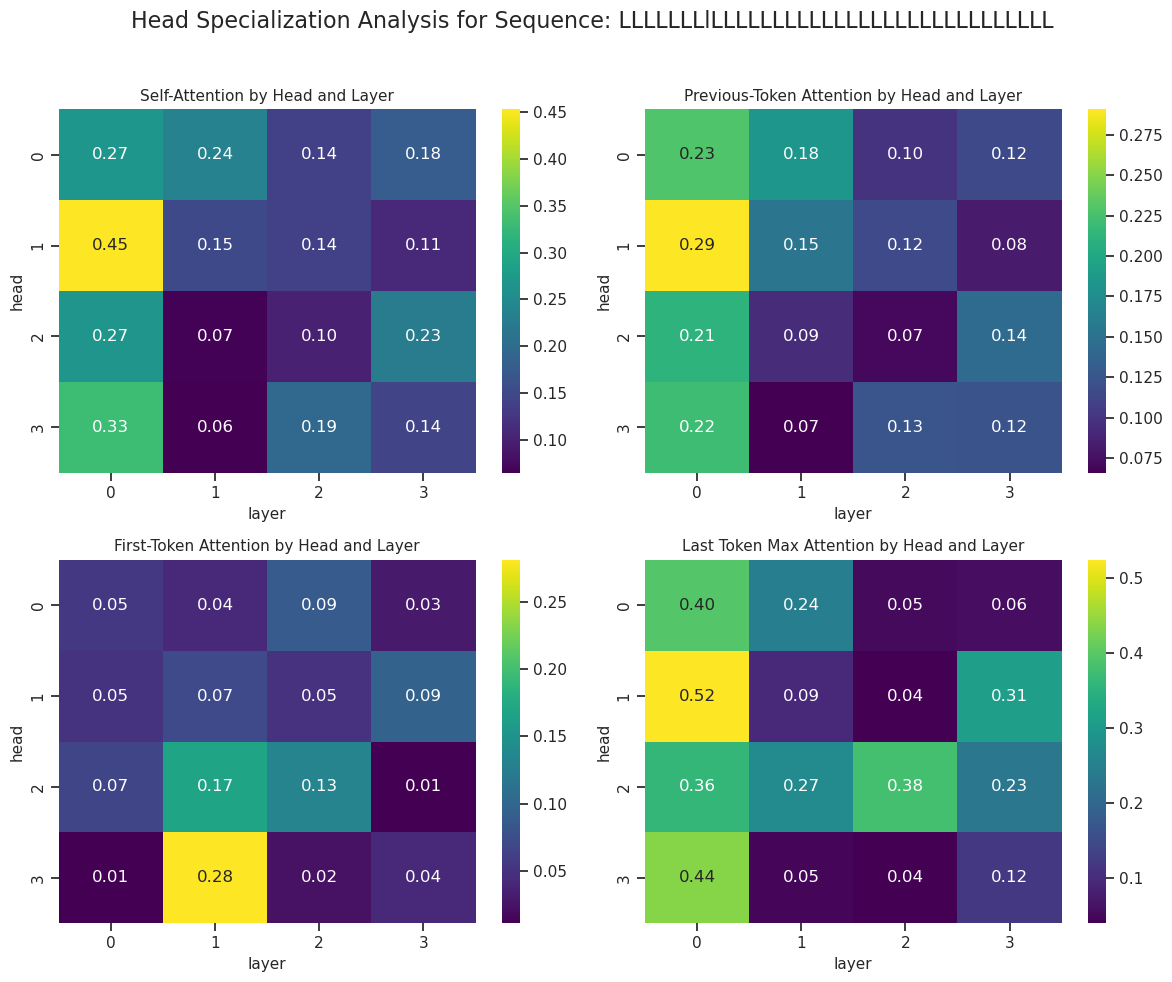

Top specialized heads for outcome 'L':
   layer  head  max_attention max_attention_pos
1      0     1       0.523986          (35, 35)
3      0     3       0.436610          (35, 35)
0      0     0       0.395101          (35, 35)

Analyzing head specialization for outcome: R


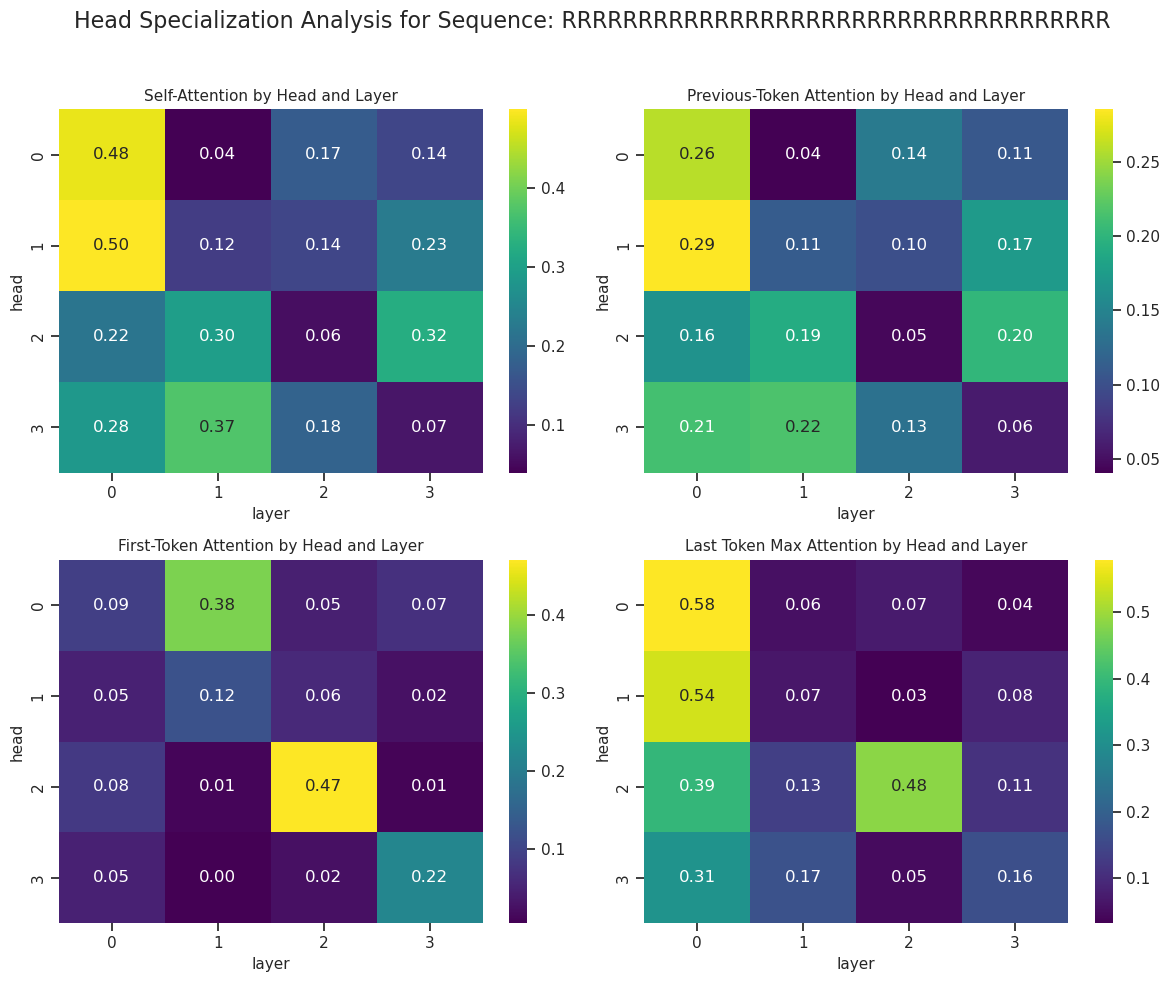

Top specialized heads for outcome 'R':
    layer  head  max_attention max_attention_pos
0       0     0       0.578867          (35, 35)
1       0     1       0.541509          (35, 35)
10      2     2       0.483230           (35, 0)


In [60]:
import random
# Group sequences by their predicted next token
outcome_sequences = {}
for seq in common_sequences[:20]:  # Use more sequences for better analysis
    input_ids = encode_sequence(seq, stoi)
    probs = predict_next_token(model, input_ids)
    next_token = vocab[np.argmax(probs)]
    
    if next_token not in outcome_sequences:
        outcome_sequences[next_token] = []
    outcome_sequences[next_token].append(seq)

# For each decision outcome, analyze head specialization
for outcome, sequences in outcome_sequences.items():
    if len(sequences) > 0:
        print(f"\n{'='*50}")
        print(f"Analyzing head specialization for outcome: {outcome}")
        print(f"{'='*50}")
        example_seq = random.choice(sequences)
        fig, df = analyze_head_specialization(example_seq)
        plt.show()
        
        # Identify specialized heads for this outcome
        top_heads = df.sort_values('max_attention', ascending=False)[['layer', 'head', 'max_attention', 'max_attention_pos']].head(3)
        print(f"Top specialized heads for outcome '{outcome}':")
        print(top_heads)

# 8. Comparing Attention at Critical Positions

L
max_attention_pos
35    222
34     47
33     39
13     21
31     20
24     18
18     17
27     16
32     14
16     13
21     13
19     13
29     11
11     11
26      9
30      9
4       9
25      9
23      8
17      8
10      8
28      8
15      7
20      7
0       6
22      6
5       6
14      5
1       4
9       4
8       4
6       4
7       3
2       3
3       3
12      3
Name: count, dtype: int64
R
max_attention_pos
35    244
33     25
0      23
34     19
1      17
23     16
32     15
31     13
26     12
29     12
28     11
2      10
24     10
22     10
13     10
27      9
25      9
12      9
21      9
30      9
19      8
10      8
16      8
14      8
11      8
15      8
9       7
7       7
8       7
18      7
5       7
3       7
20      7
6       7
17      6
4       6
Name: count, dtype: int64


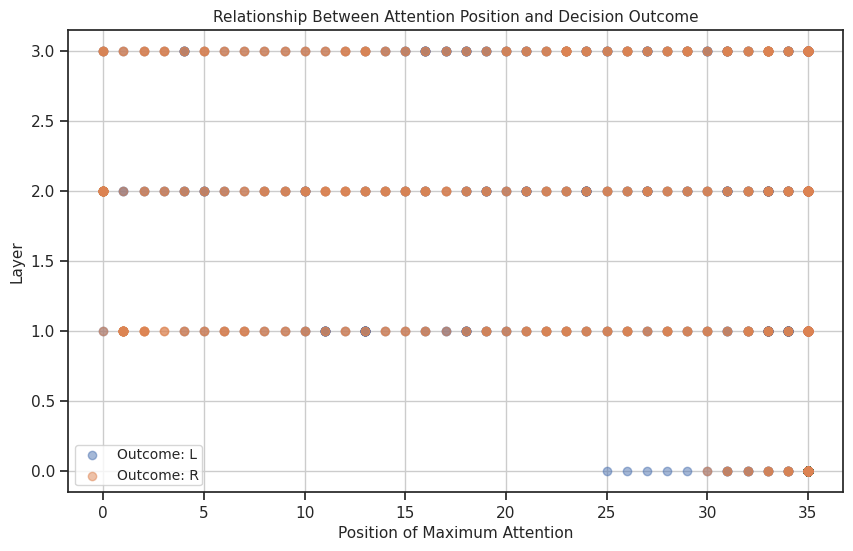

In [61]:
# Analyze attention to specific positions across different decisions
def analyze_positional_attention(sequences, position_idx=-1):
    """Analyze how attention to specific positions affects decisions"""
    position_data = []
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        attention_maps = get_attention_maps(model, input_ids)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        # Extract attention at the specified position
        for l in range(len(attention_maps)):
            for h in range(attention_maps[l].shape[1]):
                # Get attention from the last token to all positions
                att_pattern = attention_maps[l][0, h, -1, :]
                
                position_data.append({
                    'sequence': seq,
                    'next_token': next_token,
                    'layer': l,
                    'head': h,
                    'attention_scores': att_pattern.tolist(),
                    'max_attention_pos': np.argmax(att_pattern)
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(position_data)
    return df

# Run position analysis
#top 100 common sequences
position_df = analyze_positional_attention(vc[vc > 50].index.tolist()[:100])

# Visualize relationship between attention position and decision
plt.figure(figsize=(10, 6))
for token in position_df['next_token'].unique():
    token_df = position_df[position_df['next_token'] == token]
    print(token)
    print(token_df['max_attention_pos'].value_counts())
    plt.scatter(token_df['max_attention_pos'], token_df['layer'], 
                label=f"Outcome: {token}", alpha=0.5)
    # Print token and position of maximum attention
plt.xlabel('Position of Maximum Attention')
plt.ylabel('Layer')
plt.title('Relationship Between Attention Position and Decision Outcome')
plt.legend()
plt.grid(True)
plt.show()

# 9. Distinctive Attention Patterns by Decision

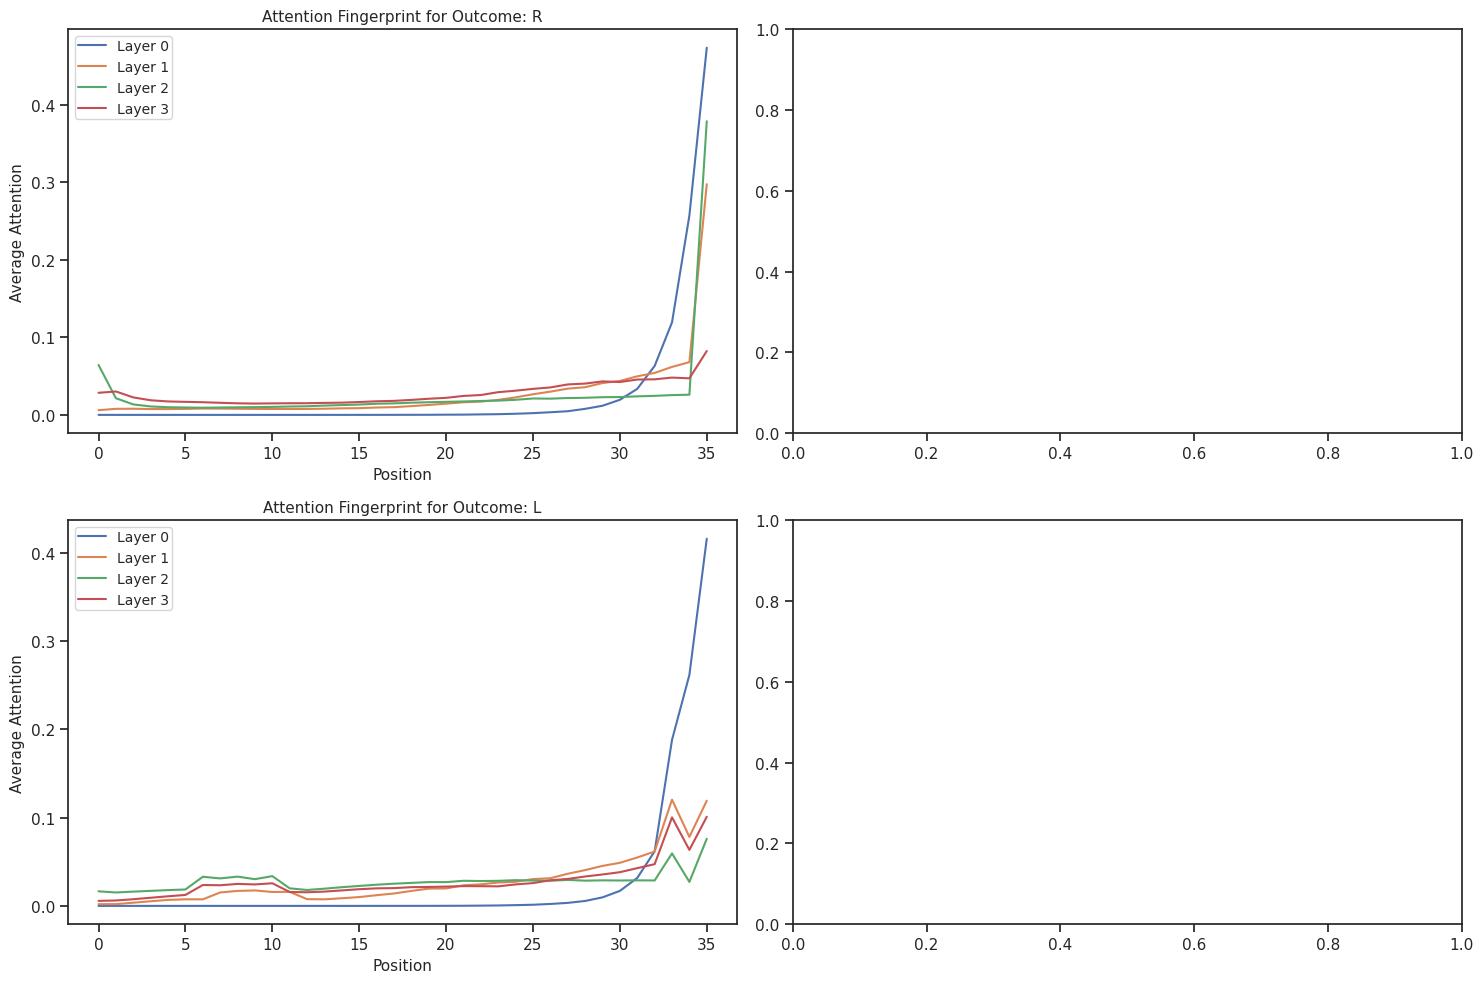

In [11]:
# For each sequence, get layer-wise attention patterns
def get_attention_fingerprint(sequences):
    fingerprints = []
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        attention_maps = get_attention_maps(model, input_ids)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        # Get attention from last token to all positions for each layer
        layer_patterns = []
        for l in range(len(attention_maps)):
            # Average across heads
            avg_pattern = np.mean([attention_maps[l][0, h, -1, :] for h in range(attention_maps[l].shape[1])], axis=0)
            layer_patterns.append(avg_pattern)
        
        fingerprints.append({
            'sequence': seq,
            'next_token': next_token,
            'layer_patterns': layer_patterns
        })
    
    return fingerprints

# Run fingerprint analysis
fingerprints = get_attention_fingerprint(common_sequences[:100])

# Visualize attention fingerprints by decision type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, token in enumerate(vocab):
    if i < len(axes):
        ax = axes[i]
        token_fingerprints = [f for f in fingerprints if f['next_token'] == token]
        
        if token_fingerprints:
            # Plot average attention pattern across layers
            for l in range(len(token_fingerprints[0]['layer_patterns'])):
                layer_data = [f['layer_patterns'][l] for f in token_fingerprints]
                avg_pattern = np.mean(np.array([p[:len(min(layer_data, key=len))] for p in layer_data]), axis=0)
                ax.plot(range(len(avg_pattern)), avg_pattern, label=f'Layer {l}')
            
            ax.set_title(f'Attention Fingerprint for Outcome: {token}')
            ax.set_xlabel('Position')
            ax.set_ylabel('Average Attention')
            ax.legend()

plt.tight_layout()
plt.show()

# 10. Analysis between close decisions 'Competing choices'

In [ ]:
# Select sequences that result in different decisions but are similar
def find_critical_sequences():
    critical_pairs = []
    
    for i, seq1 in enumerate(common_sequences[:100]):
        input_ids1 = encode_sequence(seq1, stoi)
        probs1 = predict_next_token(model, input_ids1)
        next_token1 = vocab[np.argmax(probs1)]
        
        for j, seq2 in enumerate(common_sequences[:100]):
            if i != j:
                input_ids2 = encode_sequence(seq2, stoi)
                probs2 = predict_next_token(model, input_ids2)
                next_token2 = vocab[np.argmax(probs2)]
                
                # If decisions differ but sequences are similar
                if next_token1 != next_token2:
                    # Calculate sequence similarity
                    similarity = sum(1 for a, b in zip(seq1, seq2) if a == b) / max(len(seq1), len(seq2))
                    if similarity > 0.0:  # If sequences are at least 50% similar -- shit is not working rn
                        critical_pairs.append((seq1, seq2, next_token1, next_token2, similarity))
    
    # Sort by similarity
    critical_pairs.sort(key=lambda x: x[4], reverse=True)
    return critical_pairs[:5]  # Return top 5 most similar pairs with different outcomes

# Find and analyze critical sequence pairs
critical_pairs = find_critical_sequences()
print("Hello Worlds")
print(critical_pairs)

# Compare attention patterns for critical pairs
for seq1, seq2, token1, token2, similarity in critical_pairs:
    print(f"\nComparing sequences with {similarity:.2%} similarity but different outcomes:")
    print(f"Sequence 1: {seq1} → {token1}")
    print(f"Sequence 2: {seq2} → {token2}")
    
    # Compare attention patterns for this pair in a few specific layers/heads
    compare_attention_for_sequences([seq1, seq2], layer_idx=0, head_idx=0)
    plt.show()

Hello Worlds
[]


## 11. Summary of Findings

Some interesting preliminary results
- Pays more attention to misses. 
- Layers make it hard to interpret